In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Setup and Imports

In [15]:
# %%
import os
from os import path
import glob
import pandas as pd
import numpy as np
import wget
# from github import Github # Not used in the final flow, can be removed if not needed elsewhere
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# Signal Processing / Feature Extraction related
from scipy import signal # Keep this
from scipy.signal import butter, filtfilt # **** ADD THIS LINE ****
from scipy.ndimage import label as sci_label
from scipy.stats import zscore, kurtosis, skew
from scipy.interpolate import interp1d
from numpy import trapz
import statistics
import neurokit2 as nk # **** ADD THIS LINE FOR NEUROKIT2 ****

# Scikit-learn specific
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# Balancing
from imblearn.over_sampling import SMOTE

# Other ML Models
from xgboost import XGBClassifier

# Tensorflow (Optional: only if initial DL model part is kept/run)
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM, Embedding, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D

# Settings
warnings.filterwarnings('ignore') # Ignore warnings for cleaner output
pd.set_option('display.max_columns', None) # Show all columns in DataFrames

print("Libraries imported successfully.")

Libraries imported successfully.


## 2. Configuration and Data Loading

In [4]:
print("\n--- Section 2: Configuration and Data Loading ---")
# --- Configuration: PLEASE UPDATE THESE PATHS ---
base_data_path = '/content/drive/MyDrive/ECG_GSR_Emotions'
raw_multimodal_ecg_path = os.path.join(base_data_path, 'Raw Data', 'Multimodal', 'ECG')
raw_singlemodal_ecg_path = os.path.join(base_data_path, 'Raw Data', 'Single Modal', 'ECG')
stimulus_desc_file_path = os.path.join(base_data_path, 'Stimulus_Description.xlsx')
self_annotation_multimodal_path = os.path.join(base_data_path, 'Self-Annotation Labels', 'Self-annotation Multimodal_Use.xlsx')
self_annotation_singlemodal_path = os.path.join(base_data_path, 'Self-Annotation Labels', 'Self-annotation Single Modal_Use.xlsx')
output_dir = os.path.join(base_data_path, 'Processed_Output') # Define an output directory
# --

# Create output directories if they don't exist
os.makedirs(raw_multimodal_ecg_path, exist_ok=True)
os.makedirs(raw_singlemodal_ecg_path, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

# Optional: Clean up previous CSV/XLSX files in the *current* working directory (be careful)
# print("Cleaning up old files...")
# for f in glob.glob('*.csv'): os.remove(f)
# for f in glob.glob('*.xlsx'): os.remove(f)

print(f"Base data path: {base_data_path}")
print(f"Multimodal ECG path: {raw_multimodal_ecg_path}")
print(f"Singlemodal ECG path: {raw_singlemodal_ecg_path}")
print(f"Output directory: {output_dir}")

# Load and combine annotation files
try:
    stimulus_desc_file = pd.read_excel(stimulus_desc_file_path)
    stimulus_desc_file.to_csv('Stimulus_Description.csv', index = None, header=True)
    stimulus_desc = pd.read_csv('Stimulus_Description.csv')

    self_annotation_multimodal_file = pd.read_excel(self_annotation_multimodal_path)
    self_annotation_multimodal_file.to_csv('Self-annotation Multimodal_Use.csv', index = None, header=True)
    self_annotation_multimodal = pd.read_csv('Self-annotation Multimodal_Use.csv')
    self_annotation_multimodal['annotation'] = 'M'
    self_annotation_multimodal.rename(columns = {'V_Label':'Valence', 'A_Label':'Arousal', 'Four_Labels':'Four_Label'}, inplace = True)

    self_annotation_singlemodal_file = pd.read_excel(self_annotation_singlemodal_path)
    self_annotation_singlemodal_file.to_csv('Self-annotation Single Modal_Use.csv', index = None, header=True)
    self_annotation_singlemodal = pd.read_csv('Self-annotation Single Modal_Use.csv')
    self_annotation_singlemodal['annotation'] = 'S'
    self_annotation_singlemodal.rename(columns = {'Male':'Gender', 'Session Id':'Session ID', 'Video Id':'Video ID'}, inplace = True)

    # Combine annotations
    self_annotation_frames = [self_annotation_multimodal, self_annotation_singlemodal]
    merged_dataframe = pd.concat(self_annotation_frames, ignore_index=True)
    print("Annotations loaded and merged successfully.")
    # merged_dataframe.info()

except FileNotFoundError as e:
    print(f"Error loading annotation files: {e}")
    print("Please ensure the paths in the 'Configuration' section are correct.")
    # Stop execution if files aren't found
    raise


--- Section 2: Configuration and Data Loading ---
Base data path: /content/drive/MyDrive/ECG_GSR_Emotions
Multimodal ECG path: /content/drive/MyDrive/ECG_GSR_Emotions/Raw Data/Multimodal/ECG
Singlemodal ECG path: /content/drive/MyDrive/ECG_GSR_Emotions/Raw Data/Single Modal/ECG
Output directory: /content/drive/MyDrive/ECG_GSR_Emotions/Processed_Output
Annotations loaded and merged successfully.


## 3. Load Raw ECG Data and Merge with Annotations

In [5]:
print("\n--- Section 3: Load Raw ECG Data ---")
arr_shape = 1000 # Define the length to process for each ECG signal
raw_data_arr = []

def form_data(data_array, annotation_type, data_path, annotations_df, stimulus_df):
    print(f"Processing files from: {data_path} for annotation type: {annotation_type}")
    files_processed = 0
    files_skipped_load_error = 0
    files_skipped_no_match = 0

    if not os.path.exists(data_path):
        print(f"Warning: Directory not found - {data_path}. Skipping.")
        return data_array, 0, 0, 0

    for filename in os.listdir(data_path):
        if not filename.endswith('.dat'): # Process only .dat files
            continue

        file_path = os.path.join(data_path, filename)
        try:
            data = np.loadtxt(file_path, delimiter=',')
            if len(data) < arr_shape:
                # Optional: Pad shorter signals if needed, or skip
                # print(f"Warning: Signal {filename} shorter than {arr_shape}, skipping.")
                # continue
                # Padding example (use with caution):
                pad_width = arr_shape - len(data)
                data = np.pad(data, (0, pad_width), 'constant', constant_values=0)
            else:
                data = data[0:arr_shape] # Truncate longer signals

            # Extract IDs from filename (handle potential errors)
            try:
                base_name = filename.split('ECGdata_')[1].split('.dat')[0].lower()
                s_part = base_name.split('s')[1]
                s = int(s_part.split('p')[0])
                p_part = s_part.split('p')[1]
                p = int(p_part.split('v')[0])
                v = int(p_part.split('v')[1])
            except (IndexError, ValueError) as e:
                # print(f"Warning: Could not parse IDs from filename {filename}. Error: {e}. Skipping.")
                files_skipped_load_error += 1
                continue

            # Find matching annotation row
            data_row = annotations_df.loc[
                (annotations_df['Session ID'] == s) &
                (annotations_df['Participant Id'] == p) &
                (annotations_df['Video ID'] == v) &
                (annotations_df['annotation'] == annotation_type)
            ]

            # Find matching stimulus row
            stim_row = stimulus_df.loc[
                (stimulus_df['Session ID'] == s) &
                (stimulus_df['Video ID'] == v)
            ]

            if not data_row.empty and not stim_row.empty:
                # Add data and annotations to the list
                for index, row in data_row.iterrows(): # Should typically be one row, but loop just in case
                    data_array.append([
                        data,
                        row['Participant Id'], row['Session ID'], row['Video ID'],
                        row['Name'], row['Age'], row['Gender'], row['Valence level'],
                        row['Arousal level'], row['Dominance level'], row['Happy'],
                        row['Sad'], row['Fear'], row['Anger'], row['Neutral'],
                        row['Disgust'], row['Surprised'], row['Familiarity Score'],
                        row['Emotion'], row['Valence'], row['Arousal'], row['Four_Label'],
                        row['annotation'],
                        stim_row['Target Emotion'].iloc[0] # Use iloc[0] assuming one match
                    ])
                files_processed += 1
            else:
                # print(f"Warning: No matching annotation/stimulus found for S{s}P{p}V{v} ({annotation_type}). Skipping.")
                files_skipped_no_match += 1

        except Exception as e:
            print(f"Error loading or processing file {filename}: {e}. Skipping.")
            files_skipped_load_error += 1
            continue

    print(f"Finished processing {annotation_type}. Processed: {files_processed}, Skipped (Load Error): {files_skipped_load_error}, Skipped (No Match): {files_skipped_no_match}")
    return data_array, files_processed, files_skipped_load_error, files_skipped_no_match

# Process both multimodal and single modal data
total_processed = 0
total_skipped_load = 0
total_skipped_match = 0

raw_data_arr, processed, skipped_load, skipped_match = form_data(
    raw_data_arr, 'M', raw_multimodal_ecg_path, merged_dataframe, stimulus_desc
)
total_processed += processed
total_skipped_load += skipped_load
total_skipped_match += skipped_match

raw_data_arr, processed, skipped_load, skipped_match = form_data(
    raw_data_arr, 'S', raw_singlemodal_ecg_path, merged_dataframe, stimulus_desc
)
total_processed += processed
total_skipped_load += skipped_load
total_skipped_match += skipped_match

# Define columns for the DataFrame
cols = [
    'Raw Data', 'Participant Id', 'Session ID', 'Video ID', 'Name', 'Age',
    'Gender', 'Valence level', 'Arousal level', 'Dominance level', 'Happy',
    'Sad', 'Fear', 'Anger', 'Neutral', 'Disgust', 'Surprised',
    'Familiarity Score', 'Emotion', 'Valence', 'Arousal', 'Four_Label',
    'annotation', 'Target Emotion'
]

if raw_data_arr: # Check if any data was loaded
    raw_dataframe = pd.DataFrame(raw_data_arr, columns=cols)
    raw_dataframe.rename(columns={'Participant Id': 'Participant ID', 'annotation': 'Modal', 'Four_Label': 'Four label'}, inplace=True)
    raw_dataframe['Familiarity Score'] = raw_dataframe['Familiarity Score'].fillna('Never watched')
    raw_dataframe = raw_dataframe.replace(np.nan, '', regex=True) # Replace NaN with empty string cautiously

    print(f"\nTotal files processed successfully: {total_processed}")
    print(f"Total files skipped (load/parse error): {total_skipped_load}")
    print(f"Total files skipped (no annotation/stimulus match): {total_skipped_match}")
    print("Raw DataFrame created:")
    print(raw_dataframe.info())
    # print(raw_dataframe.head())
else:
    print("\nError: No data was loaded successfully. Cannot create DataFrame.")
    print("Please check file paths, file formats, and filenames.")
    # Stop execution if no data
    raise ValueError("No data loaded into raw_data_arr")


--- Section 3: Load Raw ECG Data ---
Processing files from: /content/drive/MyDrive/ECG_GSR_Emotions/Raw Data/Multimodal/ECG for annotation type: M
Finished processing M. Processed: 247, Skipped (Load Error): 0, Skipped (No Match): 5
Processing files from: /content/drive/MyDrive/ECG_GSR_Emotions/Raw Data/Single Modal/ECG for annotation type: S
Finished processing S. Processed: 147, Skipped (Load Error): 0, Skipped (No Match): 7

Total files processed successfully: 394
Total files skipped (load/parse error): 0
Total files skipped (no annotation/stimulus match): 12
Raw DataFrame created:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Raw Data           406 non-null    object
 1   Participant ID     406 non-null    int64 
 2   Session ID         406 non-null    int64 
 3   Video ID           406 non-null    int64 
 4   Name           

## 4. Feature Extraction (HRV Features)


--- Section 4: Feature Extraction (using NeuroKit2 for HRV features) ---
Custom statistical functions (skewness, kurtosis) for NNIs defined.
Starting feature extraction at: 2025-05-13 18:21:14.394537
Processing 406 signals using NeuroKit2 for R-peak detection and HRV feature extraction...
Feature extraction completed at: 2025-05-13 18:21:46.951288
Duration: 0:00:32.556751

Extracted Features DataFrame (using NeuroKit2 for HRV):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Participant ID  406 non-null    int64  
 1   Session ID      406 non-null    int64  
 2   Video ID        406 non-null    int64  
 3   meanrr          406 non-null    float64
 4   medianrr        406 non-null    float64
 5   sdrr            406 non-null    float64
 6   rmssd           406 non-null    float64
 7   sdrr_rmssd      406 non-null    float64
 8   hr     

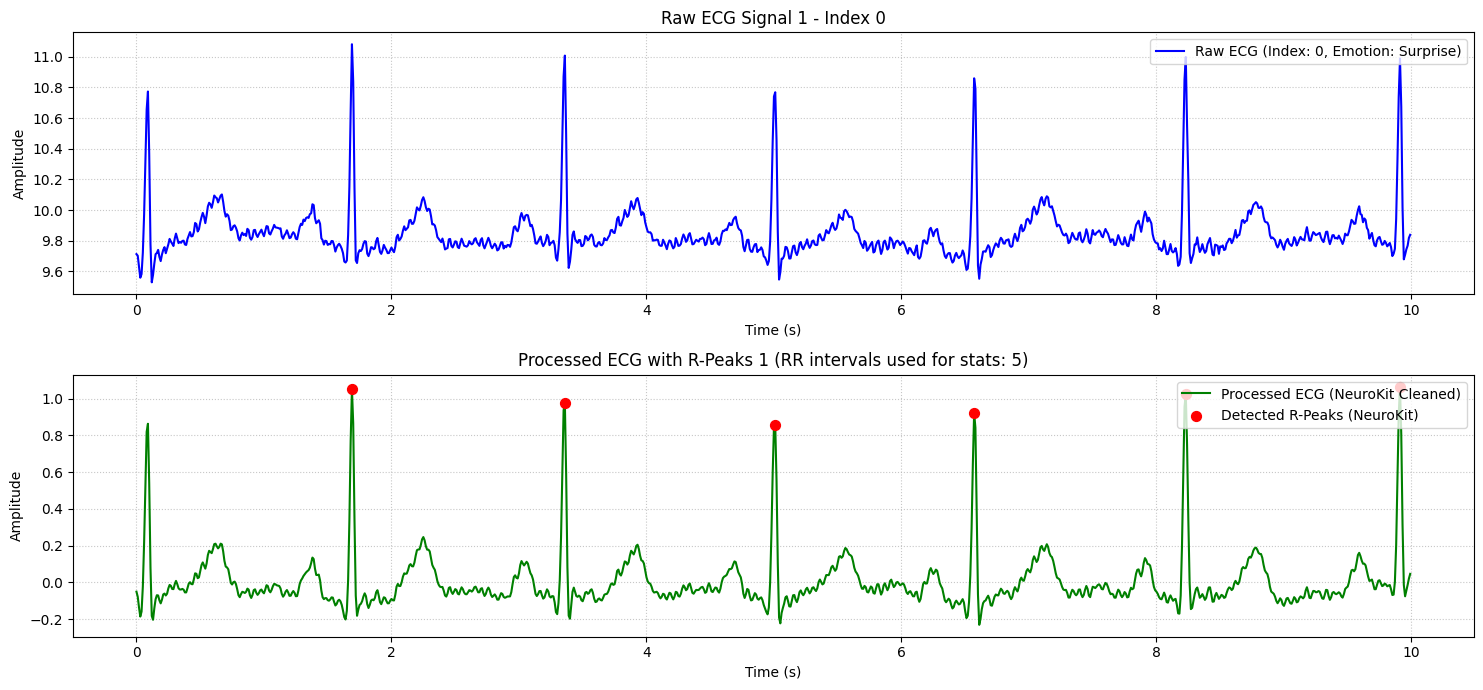

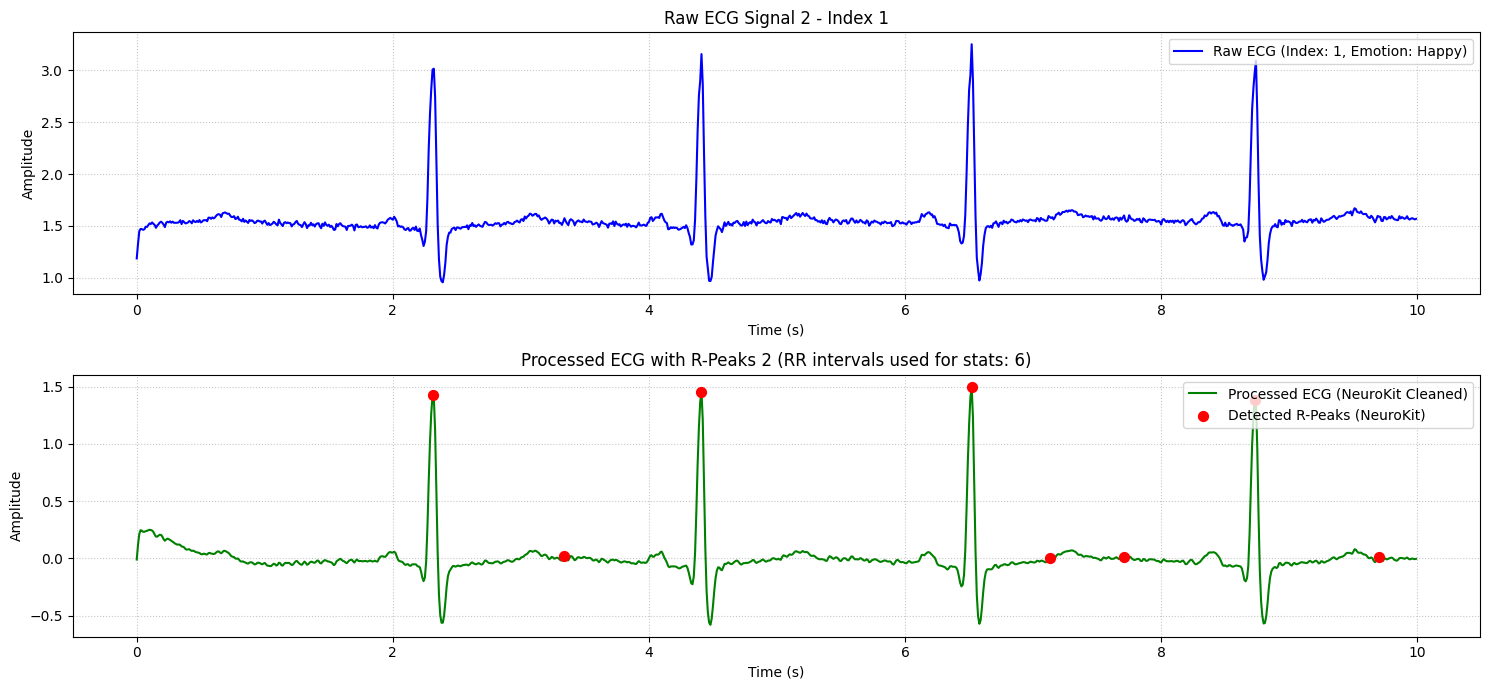

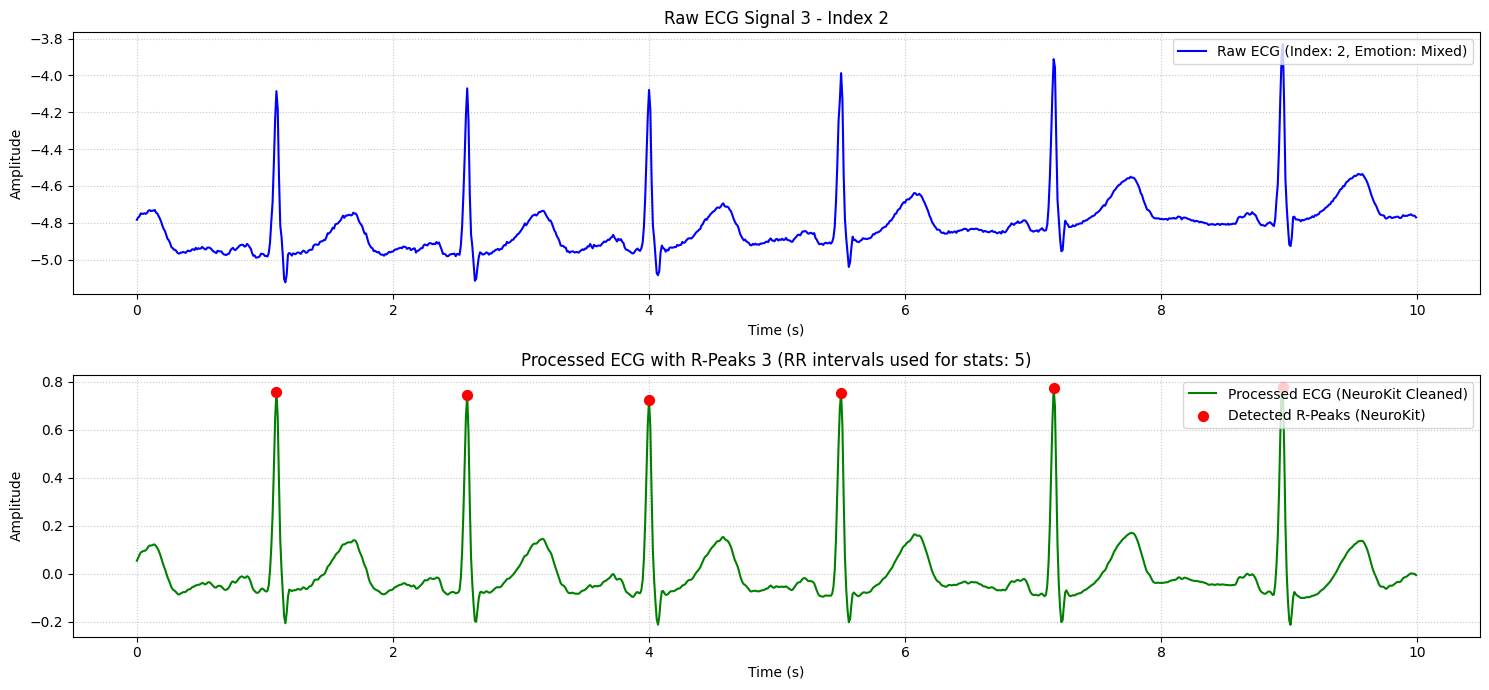

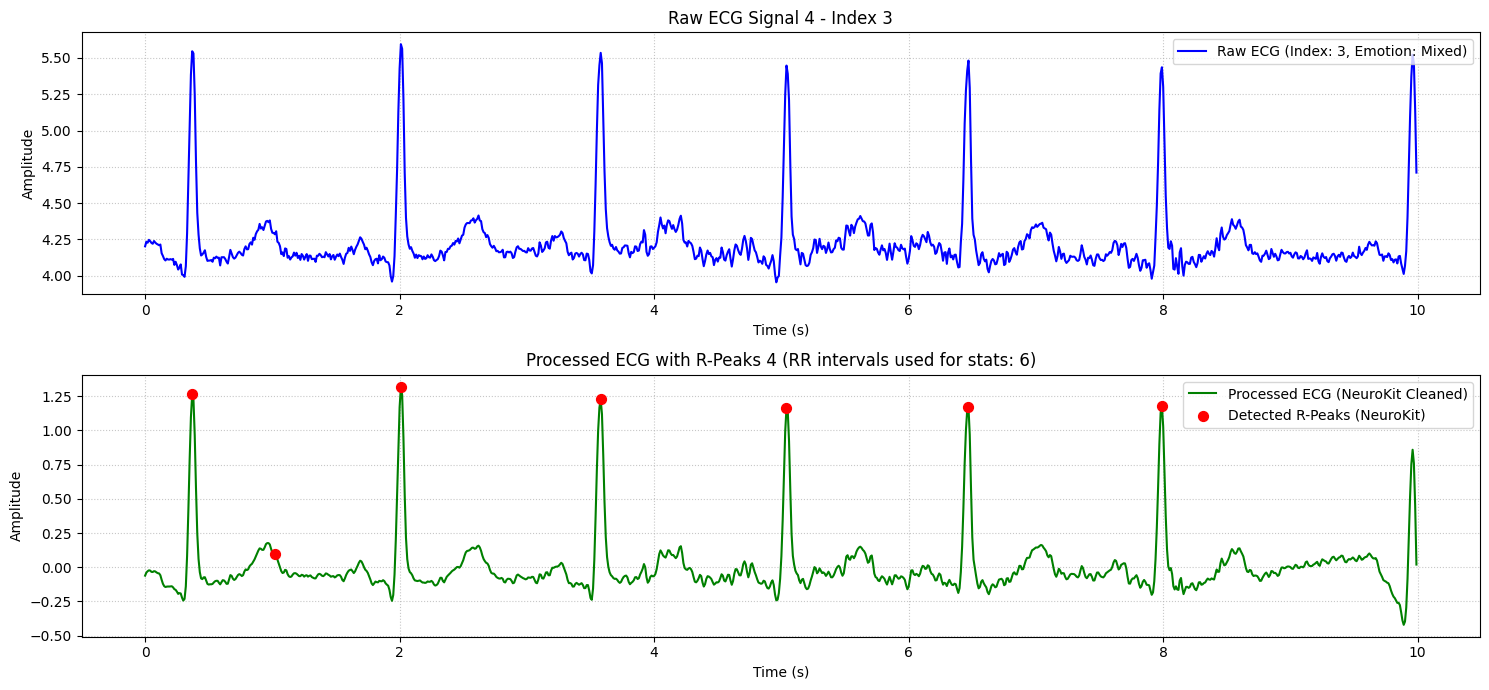

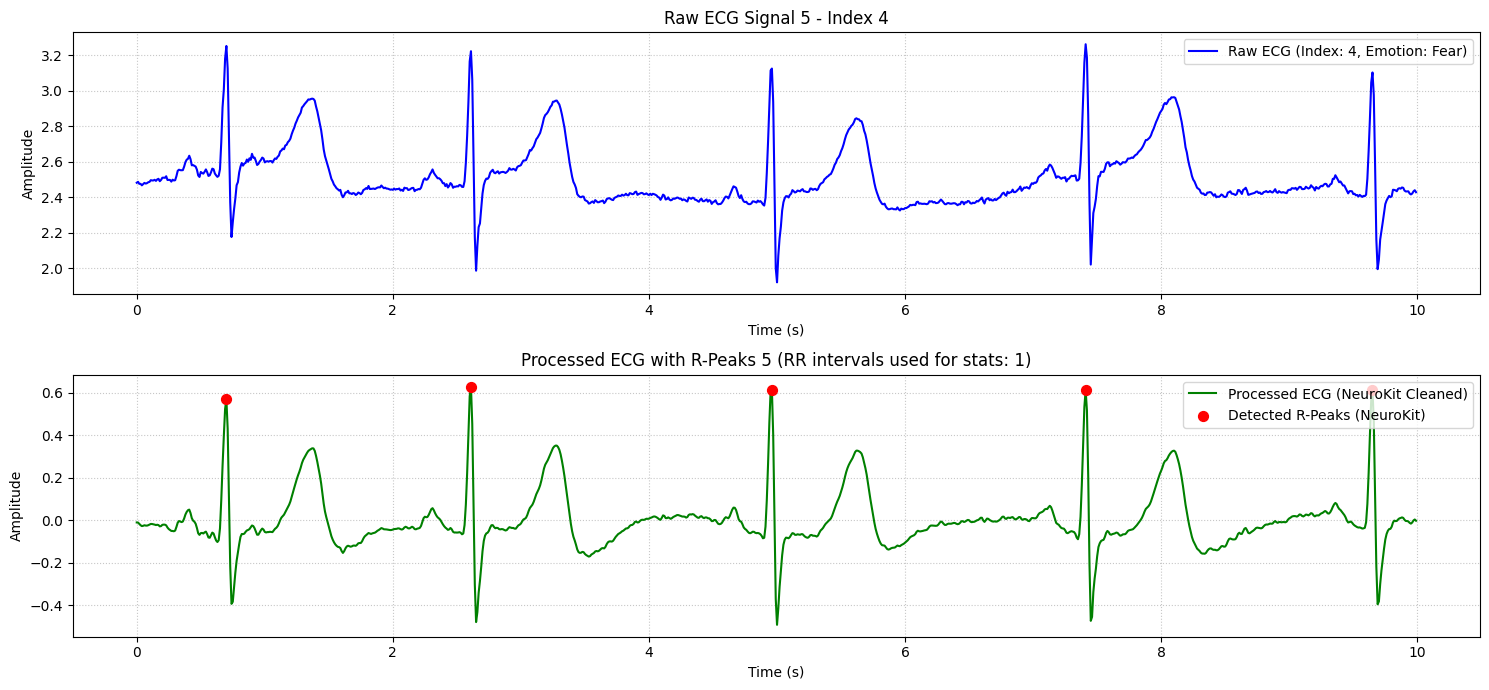


Number of rows with (nearly) all zero HRV features: 104 out of 406
A significant number of samples (104) resulted in (nearly) no HRV features.


In [6]:
# ## 4. Feature Extraction (HRV Features)

# %%
print("\n--- Section 4: Feature Extraction (using NeuroKit2 for HRV features) ---")

# These two statistical functions are still needed if you want skewness/kurtosis of NNIs,
# as NeuroKit's hrv() doesn't directly provide them for the NNI distribution.
# Ensure 'from scipy.stats import skew, kurtosis' is in your imports (Section 1)
def calc_skewness(nni_list):
    return skew(nni_list) if len(nni_list) > 0 else 0

def calc_kurtosis_val(nni_list):
    return kurtosis(nni_list) if len(nni_list) > 0 else 0

print("Custom statistical functions (skewness, kurtosis) for NNIs defined.")

# Apply feature extraction to the raw ECG data
start_time = datetime.now()
print(f"Starting feature extraction at: {start_time}")

SAMPLING_FREQUENCY = 100 # Your sampling frequency, ensure this matches your data

extracted_features_list = []
signals_for_plotting = [] # For debugging peak detection
PLOT_LIMIT = 5  # How many example signals to plot for visual inspection
plots_made = 0

# Ensure raw_dataframe is loaded and available from Section 3
if 'raw_dataframe' not in locals() or raw_dataframe.empty:
    print("Error: raw_dataframe is not defined or is empty. Please run Section 3 first.")
    # Optionally, raise an error or stop execution
    raise ValueError("raw_dataframe not found. Cannot proceed with feature extraction.")
else:
    print(f"Processing {len(raw_dataframe)} signals using NeuroKit2 for R-peak detection and HRV feature extraction...")

    for index, row in raw_dataframe.iterrows():
        ecg_signal_original = row['Raw Data'] # Keep original for plotting raw

        # Initialize all features to 0 as a robust default
        meanrr, medianrr, sdrr, rmssd, sdrr_rmssd, hr, nn50, pnn50, \
        sd1, sd2, sd1_sd2_ratio, skewness_val, kurt_val = [0.0] * 13

        # Initialize plot variables with fallbacks
        # Ensure ecg_signal_original is an array for plotting
        if not isinstance(ecg_signal_original, np.ndarray):
            ecg_signal_plot_raw = np.array(ecg_signal_original).astype(float)
        else:
            ecg_signal_plot_raw = ecg_signal_original.astype(float)

        processed_ecg_for_plot = ecg_signal_plot_raw # Fallback to raw if NK processing fails early
        peaks_for_plot = np.empty(0)
        rr_intervals_for_stats = np.empty(0) # For skewness/kurtosis

        ecg_signal_to_process = ecg_signal_plot_raw.copy() # Use a copy for processing

        # Ensure signal is not empty and is 1D
        if ecg_signal_to_process.ndim != 1 or len(ecg_signal_to_process) == 0:
            # print(f"Warning: Signal at index {index} is not a valid 1D array or is empty. Skipping processing.")
            pass # Features remain 0
        elif len(ecg_signal_to_process) < SAMPLING_FREQUENCY * 2: # Need at least a few seconds
            # print(f"Warning: Signal at index {index} is too short ({len(ecg_signal_to_process)} samples) for robust NeuroKit2 processing.")
            pass # Features remain 0
        else:
            try:
                # Process ECG signal using NeuroKit2 to find R-peaks
                ecg_signals_nk, info_nk = nk.ecg_process(ecg_signal_to_process, sampling_rate=SAMPLING_FREQUENCY)
                rpeaks_indices_nk = info_nk['ECG_R_Peaks']
                processed_ecg_for_plot = ecg_signals_nk["ECG_Clean"].values # Use NK's cleaned signal
                peaks_for_plot = rpeaks_indices_nk

                if len(rpeaks_indices_nk) >= 5: # Need a reasonable number of R-peaks for nk.hrv()
                    # Calculate RR intervals in ms for skewness/kurtosis later
                    rr_intervals_samples_temp = np.diff(rpeaks_indices_nk)
                    rr_intervals_ms_temp = (rr_intervals_samples_temp / SAMPLING_FREQUENCY) * 1000.0
                    rr_intervals_for_stats = rr_intervals_ms_temp[(rr_intervals_ms_temp > 300) & (rr_intervals_ms_temp < 2000)]

                    # Get comprehensive HRV features using NeuroKit2's hrv function
                    # This function internally calls hrv_time, hrv_frequency, hrv_nonlinear
                    hrv_features_nk = nk.hrv(rpeaks_indices_nk, sampling_rate=SAMPLING_FREQUENCY, show=False)

                    # Extract features (handle potential missing keys or NaN values from hrv_features_nk)
                    meanrr = hrv_features_nk['HRV_MeanNN'].iloc[0] if 'HRV_MeanNN' in hrv_features_nk and not pd.isna(hrv_features_nk['HRV_MeanNN'].iloc[0]) else 0.0
                    medianrr = hrv_features_nk['HRV_MedianNN'].iloc[0] if 'HRV_MedianNN' in hrv_features_nk and not pd.isna(hrv_features_nk['HRV_MedianNN'].iloc[0]) else 0.0
                    sdrr = hrv_features_nk['HRV_SDNN'].iloc[0] if 'HRV_SDNN' in hrv_features_nk and not pd.isna(hrv_features_nk['HRV_SDNN'].iloc[0]) else 0.0
                    rmssd = hrv_features_nk['HRV_RMSSD'].iloc[0] if 'HRV_RMSSD' in hrv_features_nk and not pd.isna(hrv_features_nk['HRV_RMSSD'].iloc[0]) else 0.0

                    hr = hrv_features_nk['HRV_MeanHeartRate'].iloc[0] if 'HRV_MeanHeartRate' in hrv_features_nk and not pd.isna(hrv_features_nk['HRV_MeanHeartRate'].iloc[0]) else (60000.0 / meanrr if meanrr > 0 else 0.0)

                    nn50 = hrv_features_nk['HRV_NN50'].iloc[0] if 'HRV_NN50' in hrv_features_nk and not pd.isna(hrv_features_nk['HRV_NN50'].iloc[0]) else 0.0
                    pnn50 = hrv_features_nk['HRV_pNN50'].iloc[0] if 'HRV_pNN50' in hrv_features_nk and not pd.isna(hrv_features_nk['HRV_pNN50'].iloc[0]) else 0.0

                    sd1 = hrv_features_nk['HRV_SD1'].iloc[0] if 'HRV_SD1' in hrv_features_nk and not pd.isna(hrv_features_nk['HRV_SD1'].iloc[0]) else 0.0
                    sd2 = hrv_features_nk['HRV_SD2'].iloc[0] if 'HRV_SD2' in hrv_features_nk and not pd.isna(hrv_features_nk['HRV_SD2'].iloc[0]) else 0.0

                    # Calculated ratios (handle division by zero)
                    sdrr_rmssd = sdrr / rmssd if rmssd != 0 else 0.0
                    sd1_sd2_ratio = sd1 / sd2 if sd2 != 0 else 0.0

                    # Skewness and Kurtosis on the NNI distribution
                    if len(rr_intervals_for_stats) > 0:
                        skewness_val = calc_skewness(rr_intervals_for_stats)
                        kurt_val = calc_kurtosis_val(rr_intervals_for_stats)
                    else: # Should not happen if len(rpeaks_indices_nk) >= 5
                        skewness_val = 0.0
                        kurt_val = 0.0
                else: # Not enough R-peaks for robust nk.hrv()
                    # print(f"Not enough R-peaks ({len(rpeaks_indices_nk)}) at index {index} for full HRV analysis via NeuroKit.")
                    pass # Features remain 0
            except Exception as e:
                # print(f"Error processing signal at index {index} with NeuroKit2 or calculating HRV: {e}")
                pass # Features remain 0

        # Add data for plotting
        if plots_made < PLOT_LIMIT:
            signals_for_plotting.append({
                'raw_ecg': ecg_signal_plot_raw,
                'filtered_ecg': processed_ecg_for_plot,
                'peaks': peaks_for_plot,
                'rr': rr_intervals_for_stats, # Storing the NNI list used for skew/kurt
                'label': row['Emotion'],
                'index': index
            })
            plots_made += 1

        extracted_features_list.append([
            row['Participant ID'], row['Session ID'], row['Video ID'],
            meanrr, medianrr, sdrr, rmssd, sdrr_rmssd, hr, nn50, pnn50,
            sd1, sd2, sd1_sd2_ratio, skewness_val, kurt_val,
            row['Emotion']
        ])

# Create DataFrame from the list of features
feature_columns = [
    'Participant ID', 'Session ID', 'Video ID',
    'meanrr', 'medianrr', 'sdrr', 'rmssd', 'sdrr_rmssd', 'hr', 'nn50', 'pnn50',
    'sd1', 'sd2', 'sd1_sd2_ratio', 'skewness', 'kurtosis', # Ensure these match your model expectations
    'emotion'
]
features_df = pd.DataFrame(extracted_features_list, columns=feature_columns)
features_df = features_df.fillna(0.0) # Ensure NaNs from any source become 0

end_time = datetime.now()
print(f"Feature extraction completed at: {end_time}")
print(f"Duration: {end_time - start_time}")
print("\nExtracted Features DataFrame (using NeuroKit2 for HRV):")
print(features_df.info())
# print(features_df.describe()) # Good to see a statistical summary of features

# VISUALIZE PEAK DETECTION FOR A FEW SAMPLES
print("\n--- Visualizing Peak Detection on a Few Samples (using NeuroKit2 derived data) ---")
for i, plot_data in enumerate(signals_for_plotting):
    plt.figure(figsize=(15, 7))
    plt.subplot(2, 1, 1)
    time_axis_raw = np.arange(len(plot_data['raw_ecg'])) / SAMPLING_FREQUENCY
    plt.plot(time_axis_raw, plot_data['raw_ecg'], label=f'Raw ECG (Index: {plot_data["index"]}, Emotion: {plot_data["label"]})', color='blue')
    plt.title(f'Raw ECG Signal {i+1} - Index {plot_data["index"]}')
    plt.xlabel("Time (s)"); plt.ylabel("Amplitude"); plt.legend(loc='upper right'); plt.grid(True, linestyle=':', alpha=0.7)

    plt.subplot(2, 1, 2)
    time_axis_filt = np.arange(len(plot_data['filtered_ecg'])) / SAMPLING_FREQUENCY
    plt.plot(time_axis_filt, plot_data['filtered_ecg'], label='Processed ECG (NeuroKit Cleaned)', color='green')
    if len(plot_data['peaks']) > 0:
        valid_peaks = plot_data['peaks'][plot_data['peaks'] < len(plot_data['filtered_ecg'])]
        if len(valid_peaks) > 0:
            plt.scatter(valid_peaks / SAMPLING_FREQUENCY, plot_data['filtered_ecg'][valid_peaks], color='red', s=50, zorder=5, label='Detected R-Peaks (NeuroKit)')
    plt.title(f'Processed ECG with R-Peaks {i+1} (RR intervals used for stats: {len(plot_data["rr"])})')
    plt.xlabel("Time (s)"); plt.ylabel("Amplitude"); plt.legend(loc='upper right'); plt.grid(True, linestyle=':', alpha=0.7)
    plt.tight_layout(); plt.show()

# Check how many signals yielded (mostly) zero features
if not features_df.empty:
    feature_cols_only = features_df.drop(columns=['Participant ID', 'Session ID', 'Video ID', 'emotion'], errors='ignore')
    # Check if sum of absolute values of features is very small (e.g. < 0.001), indicating mostly zeros
    zero_ish_feature_rows = feature_cols_only[feature_cols_only.abs().sum(axis=1) < 0.001]
    print(f"\nNumber of rows with (nearly) all zero HRV features: {len(zero_ish_feature_rows)} out of {len(features_df)}")
    if 0 < len(zero_ish_feature_rows) < 20:
        print("Example rows (indices from features_df) with (nearly) zero features:")
        print(features_df.loc[zero_ish_feature_rows.index].head())
    elif len(zero_ish_feature_rows) > 0:
        print(f"A significant number of samples ({len(zero_ish_feature_rows)}) resulted in (nearly) no HRV features.")
else:
    print("\nfeatures_df is empty. No feature extraction results to analyze.")

## 5. Data Splitting (Train/Test)

In [7]:
# ## 5. Data Splitting (Train/Test) - MODIFIED FOR SIMPLER PROBLEM

# %%
print("\n--- Section 5: Data Splitting (Modified for Simpler Problem) ---")

# --- Option 1: Binary Classification (e.g., Valence: Positive vs. Negative) ---
# Assuming 'Happy' is positive, others might be negative or neutral
# You need to define this mapping based on your understanding of the labels
def map_emotion_to_valence(emotion):
    if emotion == 'Happy':
        return 'Positive'
    elif emotion in ['Sad', 'Anger', 'Fear', 'Disgust']:
        return 'Negative'
    # elif emotion == 'Neutral': # Decide how to handle Neutral, Surprise, Mixed
    # return 'Neutral_Combined'
    else:
        return None # Or assign to a specific category like 'Other'

features_df['valence_label'] = features_df['emotion'].apply(map_emotion_to_valence)
# Drop rows where mapping is None or a category you want to exclude for binary
simple_df = features_df.dropna(subset=['valence_label'])
# Optional: if you created 'Other' or 'Neutral_Combined' and want to exclude one
# simple_df = simple_df[simple_df['valence_label'] != 'Other']

if simple_df.empty or len(simple_df['valence_label'].unique()) < 2:
    print("Error: Not enough classes after simplifying labels. Reverting to original 'emotion'.")
    X = features_df.drop(['Participant ID', 'Session ID', 'Video ID', 'emotion'], axis=1)
    y_target_series = features_df['emotion']
else:
    print(f"Simplified problem: Target is 'valence_label' with classes: {simple_df['valence_label'].unique()}")
    print(simple_df['valence_label'].value_counts())
    X = simple_df.drop(['Participant ID', 'Session ID', 'Video ID', 'emotion', 'valence_label'], axis=1)
    y_target_series = simple_df['valence_label']
# --- End Option 1 ---

# --- Option 2: Select a few classes (e.g., Happy vs Sad vs Neutral) ---
# selected_emotions = ['Happy', 'Sad', 'Neutral']
# simple_df = features_df[features_df['emotion'].isin(selected_emotions)]
# if simple_df.empty or len(simple_df['emotion'].unique()) < 2:
#     print("Error: Not enough data for selected emotions. Reverting to original 'emotion'.")
#     X = features_df.drop(['Participant ID', 'Session ID', 'Video ID', 'emotion'], axis=1)
#     y_target_series = features_df['emotion']
# else:
#     print(f"Simplified problem: Target is 'emotion' with classes: {simple_df['emotion'].unique()}")
#     print(simple_df['emotion'].value_counts())
#     X = simple_df.drop(['Participant ID', 'Session ID', 'Video ID', 'emotion'], axis=1)
#     y_target_series = simple_df['emotion']
# --- End Option 2 ---


# Encode the (potentially simplified) target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y_target_series) # Use y_target_series here
print("Target labels encoded:", dict(zip(le.classes_, le.transform(le.classes_))))

# Split into training and testing sets
if len(np.unique(y_encoded)) < 2:
    raise ValueError("Simplified problem resulted in less than 2 classes. Cannot proceed with train_test_split with stratification.")

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

print(f"Dataset shape for modeling: {X.shape}")
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

print("\nTraining set class distribution:")
print(pd.Series(y_train).value_counts(normalize=True))
print("\nTesting set class distribution:")
print(pd.Series(y_test).value_counts(normalize=True))


--- Section 5: Data Splitting (Modified for Simpler Problem) ---
Simplified problem: Target is 'valence_label' with classes: ['Positive' 'Negative']
valence_label
Negative    143
Positive    120
Name: count, dtype: int64
Target labels encoded: {'Negative': np.int64(0), 'Positive': np.int64(1)}
Dataset shape for modeling: (263, 13)
Training set shape: (184, 13), (184,)
Testing set shape: (79, 13), (79,)

Training set class distribution:
0    0.543478
1    0.456522
Name: proportion, dtype: float64

Testing set class distribution:
0    0.544304
1    0.455696
Name: proportion, dtype: float64


## 6. Feature Scaling

In [8]:
print("\n--- Section 6: Feature Scaling ---")
# Scale features after splitting.

scaler = StandardScaler()

# Fit scaler ONLY on training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform both training and testing data using the fitted scaler
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames (optional, but maintains column names)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Features scaled using StandardScaler.")
# print(X_train_scaled.head())


--- Section 6: Feature Scaling ---
Features scaled using StandardScaler.


## 7. Feature Selection using Random Forest Importance


--- Section 7: Feature Selection ---
Running preliminary Random Forest for feature importance...
Feature Importances:
          feature  importance
0          meanrr    0.126502
10  sd1_sd2_ratio    0.125296
3           rmssd    0.096524
8             sd1    0.092782
5              hr    0.092623
1        medianrr    0.087220
9             sd2    0.082264
2            sdrr    0.080567
4      sdrr_rmssd    0.066755
12       kurtosis    0.053220
11       skewness    0.048322
7           pnn50    0.047925
6            nn50    0.000000

Selected top 10 features:
['meanrr', 'sd1_sd2_ratio', 'rmssd', 'sd1', 'hr', 'medianrr', 'sd2', 'sdrr', 'sdrr_rmssd', 'kurtosis']

Shape after feature selection:
Training set: (184, 10)
Testing set: (79, 10)


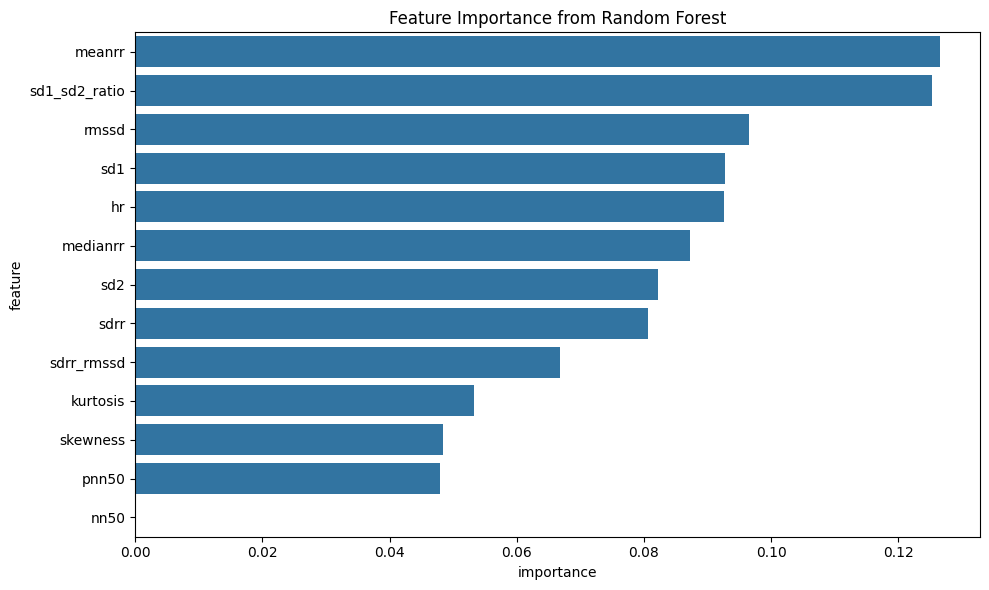

In [9]:
print("\n--- Section 7: Feature Selection ---")
# Train a preliminary Random Forest model on the *scaled training data*.

# Train a Random Forest to get feature importances
print("Running preliminary Random Forest for feature importance...")
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_selector.fit(X_train_scaled, y_train)

# Get feature importances
importances = rf_selector.feature_importances_
feature_names = X_train_scaled.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

print("Feature Importances:")
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance from Random Forest')
plt.tight_layout()
# plt.show() # Uncomment to display plot during script execution

# --- Feature Selection Strategy ---
# Strategy 1: Select features above a certain threshold (e.g., mean importance)
# importance_threshold = feature_importance_df['importance'].mean()
# selected_features = feature_importance_df[feature_importance_df['importance'] > importance_threshold]['feature'].tolist()

# Strategy 2: Select the top N features (e.g., top 10)
N_TOP_FEATURES = 10
selected_features = feature_importance_df.head(N_TOP_FEATURES)['feature'].tolist()

print(f"\nSelected top {len(selected_features)} features:")
print(selected_features)

# Apply selection to the scaled train and test sets
X_train_selected = X_train_scaled[selected_features]
X_test_selected = X_test_scaled[selected_features]

print(f"\nShape after feature selection:")
print(f"Training set: {X_train_selected.shape}")
print(f"Testing set: {X_test_selected.shape}")

## 8. Class Balancing (SMOTE)


--- Section 8: Class Balancing (SMOTE) ---
Class distribution before SMOTE (Training Data - y_train):
0    100
1     84
Name: count, dtype: int64
Calculated k_neighbors for SMOTE: 5
Attempting SMOTE with k_neighbors=5

Class distribution after SMOTE (Training Data):
1    100
0    100
Name: count, dtype: int64


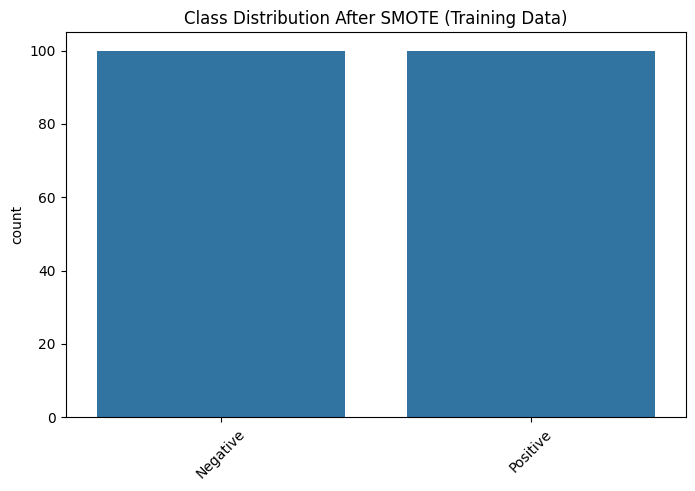


Shapes for modeling:
Original Training: X=(184, 10), y=(184,)
SMOTE Training: X=(200, 10), y=(200,)
Test Data: X=(79, 10), y=(79,)


In [10]:
print("\n--- Section 8: Class Balancing (SMOTE) ---")
# Apply SMOTE *only* to the *selected training data*.

print("Class distribution before SMOTE (Training Data - y_train):")
print(pd.Series(y_train).value_counts())

# --- OPTION 1: Use SMOTE (as originally intended but with checks) ---
# Initialize SMOTE
# 'k_neighbors' should be less than the smallest class size. Adjust if needed.
min_class_size_train = pd.Series(y_train).value_counts().min() # Check on y_train
n_neighbors_smote = min(5, min_class_size_train - 1) if min_class_size_train > 1 else 1
# n_neighbors_smote needs to be at least 1 for SMOTE to run.
# If min_class_size_train -1 is less than 1, it means min_class_size_train is 1 (or 0, though unlikely after split if present in y).

print(f"Calculated k_neighbors for SMOTE: {n_neighbors_smote}")

X_train_smote, y_train_smote = None, None # Initialize

if min_class_size_train <= n_neighbors_smote and min_class_size_train > 0 : # if smallest class is too small for default k=5
    # This condition handles cases where min_class_size_train-1 is less than the desired k_neighbors (e.g. k=5)
    # but still large enough for SMOTE (i.e. > 0). We set n_neighbors_smote to min_class_size_train - 1
    n_neighbors_smote = min_class_size_train - 1
    print(f"Adjusted k_neighbors for SMOTE to {n_neighbors_smote} due to small class size.")


if n_neighbors_smote < 1 and min_class_size_train > 0: # Smallest class size is 1. SMOTE cannot run.
    print(f"Warning: Smallest class size in training set is {min_class_size_train}, which is too small for SMOTE (k_neighbors would be < 1).")
    print("SMOTE will be skipped for the 'SMOTE' scenario. Original training data will be used instead.")
    X_train_smote = X_train_selected.copy() # Use original selected training data
    y_train_smote = y_train.copy()
elif min_class_size_train == 0 : # Should not happen if stratification worked and all classes present
    print(f"Critical Warning: Smallest class size in training set is 0. SMOTE cannot be applied.")
    # Decide how to handle this: maybe skip this model variant or raise error
    X_train_smote = X_train_selected.copy()
    y_train_smote = y_train.copy()
else:
    try:
        print(f"Attempting SMOTE with k_neighbors={n_neighbors_smote}")
        smote = SMOTE(random_state=42, k_neighbors=n_neighbors_smote)
        X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train)

        print("\nClass distribution after SMOTE (Training Data):")
        print(pd.Series(y_train_smote).value_counts())

        # Plot class distribution after SMOTE
        plt.figure(figsize=(8, 5))
        sns.countplot(x=y_train_smote) # Use y_train_smote here
        plt.title('Class Distribution After SMOTE (Training Data)')
        # Use label encoder to show original emotion names on the plot
        # Ensure `le` is the LabelEncoder fitted on the original `y`
        plt.xticks(ticks=np.arange(len(le.classes_)), labels=le.classes_, rotation=45)
        plt.show() # Uncomment to display plot during script execution

    except ValueError as e:
        print(f"Error during SMOTE: {e}. Using original selected training data for SMOTE scenario.")
        X_train_smote = X_train_selected.copy() # Fallback
        y_train_smote = y_train.copy()


# --- Final Datasets for Different Scenarios ---
# Scenario 1: Original unbalanced data (selected features)
X_train_original_selected = X_train_selected.copy()
y_train_original = y_train.copy()

# Scenario 2: SMOTE'd data (selected features)
# X_train_smote and y_train_smote are already prepared above
if X_train_smote is None: # Fallback if SMOTE failed catastrophically before try-except
    print("Fallback: SMOTE data not generated, using original for SMOTE scenario.")
    X_train_smote = X_train_selected.copy()
    y_train_smote = y_train.copy()


# The test set remains unchanged (unbalanced and selected features)
X_test_final = X_test_selected.copy() # Use a consistent name for test set features
y_test_final = y_test.copy() # Use a consistent name for test set labels

print(f"\nShapes for modeling:")
print(f"Original Training: X={X_train_original_selected.shape}, y={y_train_original.shape}")
print(f"SMOTE Training: X={X_train_smote.shape}, y={y_train_smote.shape}")
print(f"Test Data: X={X_test_final.shape}, y={y_test_final.shape}")

## 9. Feature Fusion (Conceptual Note)

In [ ]:
# Feature fusion involves creating new features by combining existing ones.
# While not explicitly implemented here, the HRV features themselves are derived
# ('fused') from the raw time-series data. Further fusion could be explored.

## 10. Standard Machine Learning Classification

In [44]:
# ## 10. Standard Machine Learning Classification (with Cross-Validation)

# %%
print("\n--- Section 10: Standard Machine Learning Classification (with Cross-Validation) ---")

from sklearn.base import clone
from sklearn.model_selection import cross_val_score, StratifiedKFold # Ensure these are imported

# Define classifiers
base_classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "SVC": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
}

training_scenarios = {
    "Original (Imbalanced)": (X_train_original_selected, y_train_original),
    "SMOTE": (X_train_smote, y_train_smote),
    "Class Weighted": (X_train_original_selected, y_train_original)
}

all_results_summary = []
trained_model_objects = {}

cv_strategy_eval = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for scenario_name, (current_X_train, current_y_train) in training_scenarios.items():
    print(f"\n\n===== EVALUATING SCENARIO (CV): {scenario_name} =====")

    if current_X_train is None or current_y_train is None or \
       len(current_X_train) == 0 or len(current_y_train) == 0 or \
       len(current_X_train) != len(current_y_train):
        print(f"Skipping scenario {scenario_name} due to invalid or empty training data.")
        continue
    if len(np.unique(current_y_train)) < 2 :
        print(f"Skipping scenario {scenario_name} as it has less than 2 classes in training data.")
        continue

    print(f"Training data shape for CV: X={current_X_train.shape}, y={current_y_train.shape}")
    print(f"Class distribution for this training data:\n{pd.Series(current_y_train).value_counts(normalize=True)}")

    trained_model_objects[scenario_name] = {}

    for model_name, clf_template in base_classifiers.items():
        clf_for_cv = clone(clf_template) # Clone for CV

        # Apply class_weight for CV if applicable
        if scenario_name == "Class Weighted":
            if hasattr(clf_for_cv, 'class_weight'):
                print(f"Applying class_weight='balanced' to {model_name} for CV.")
                clf_for_cv.set_params(class_weight='balanced')
            elif model_name == "XGBoost":
                 print(f"Note: {model_name} for 'Class Weighted' CV. XGBoost handles weights differently. Training as is for CV.")
            # No else needed, if no class_weight, it runs as is for CV.

        print(f"\n--- Cross-Validating {model_name} ({scenario_name}) ---")
        start_time_cv = datetime.now()
        avg_accuracy_cv, avg_f1_weighted_cv, std_f1_weighted_cv = 0, 0, 0

        try:
            min_samples_in_class_cv = pd.Series(current_y_train).value_counts().min()
            actual_n_splits = min(cv_strategy_eval.get_n_splits(), min_samples_in_class_cv)

            if actual_n_splits < 2:
                print(f"Warning: Smallest class in '{scenario_name}' has {min_samples_in_class_cv} samples. Cannot perform CV with n_splits={cv_strategy_eval.get_n_splits()}. Skipping CV for {model_name}.")
            else:
                current_cv_strategy_for_model = StratifiedKFold(n_splits=actual_n_splits, shuffle=True, random_state=42)
                accuracy_scores_cv = cross_val_score(clf_for_cv, current_X_train, current_y_train, cv=current_cv_strategy_for_model, scoring='accuracy', n_jobs=-1)
                f1_weighted_scores_cv = cross_val_score(clf_for_cv, current_X_train, current_y_train, cv=current_cv_strategy_for_model, scoring='f1_weighted', n_jobs=-1)
                avg_accuracy_cv = np.mean(accuracy_scores_cv)
                avg_f1_weighted_cv = np.mean(f1_weighted_scores_cv)
                std_f1_weighted_cv = np.std(f1_weighted_scores_cv)

            end_time_cv = datetime.now()
            print(f"CV Duration: {end_time_cv - start_time_cv}")
            print(f"Avg Accuracy (CV for {model_name} on {scenario_name}): {avg_accuracy_cv:.4f}")
            print(f"Avg Weighted F1 (CV for {model_name} on {scenario_name}): {avg_f1_weighted_cv:.4f} (+/- {std_f1_weighted_cv:.4f})")

        except ValueError as ve:
            print(f"VALUE ERROR during CV for {model_name} ({scenario_name}): {ve}.")
        except Exception as e_cv:
            print(f"ERROR during CV for {model_name} ({scenario_name}): {e_cv}")
        print("-------------------------")

        all_results_summary.append({
            'Scenario': scenario_name,
            'Model': model_name,
            'Accuracy_CV': avg_accuracy_cv,
            'Weighted_F1_CV': avg_f1_weighted_cv # This is the primary metric for comparison
        })

        # **** CORRECTED FITTING FOR trained_model_objects ****
        # Train the model on the *entire* current_X_train for storage
        clf_final_train = clone(clf_template) # Fresh clone for final training on full training data portion
        try:
            # Set parameters first
            if scenario_name == "Class Weighted":
                if hasattr(clf_final_train, 'class_weight'):
                    print(f"Setting class_weight='balanced' for final training of {model_name} ({scenario_name}).")
                    clf_final_train.set_params(class_weight='balanced')
                elif model_name == "XGBoost":
                    # If specific sample_weight logic for XGBoost is desired for 'Class Weighted',
                    # it would be handled during its .fit() call.
                    # Otherwise, it trains like other scenarios but was marked 'Class Weighted'.
                    print(f"Note: {model_name} in 'Class Weighted' scenario for final training. No specific 'class_weight' param set directly.")

            # Then, fit the model
            # Special handling for XGBoost with sample_weight if you choose to implement it:
            # if scenario_name == "Class Weighted" and model_name == "XGBoost" and <your_condition_for_sample_weighting>:
            #     from sklearn.utils.class_weight import compute_sample_weight
            #     sample_weights = compute_sample_weight(class_weight='balanced', y=current_y_train)
            #     print(f"Fitting final {model_name} ({scenario_name}) with sample_weight.")
            #     clf_final_train.fit(current_X_train, current_y_train, sample_weight=sample_weights)
            # else:
            print(f"Fitting final {model_name} ({scenario_name}) on full training data.")
            clf_final_train.fit(current_X_train, current_y_train) # General fit call

            trained_model_objects[scenario_name][model_name] = clf_final_train
            print(f"Successfully fitted and stored {model_name} for {scenario_name}.")

        except Exception as e_fit_final:
            print(f"ERROR fitting final model for {model_name} ({scenario_name}) on full training data: {e_fit_final}")
            trained_model_objects[scenario_name][model_name] = None # Mark as None if fitting failed

# Create summary DataFrame from CV results
overall_summary_df = pd.DataFrame(all_results_summary)
if not overall_summary_df.empty and 'Weighted_F1_CV' in overall_summary_df.columns:
    overall_summary_df = overall_summary_df.sort_values(by='Weighted_F1_CV', ascending=False)
    print("\n\n=== Overall Model Performance Summary (Based on 5-Fold Cross-Validation on Training Data) ===")
    print(overall_summary_df)
    if not overall_summary_df.empty:
        best_cv_row = overall_summary_df.iloc[0]
        print(f"\nBest performing model configuration based on CV (Weighted F1 on training data):")
        print(f"Scenario: {best_cv_row['Scenario']}, Model: {best_cv_row['Model']}, CV Weighted F1: {best_cv_row['Weighted_F1_CV']:.4f}")
else:
    print("\nNo models were successfully cross-validated or summary DataFrame is empty.")


--- Section 10: Standard Machine Learning Classification (with Cross-Validation) ---


===== EVALUATING SCENARIO (CV): Original (Imbalanced) =====
Training data shape for CV: X=(184, 10), y=(184,)
Class distribution for this training data:
0    0.543478
1    0.456522
Name: proportion, dtype: float64

--- Cross-Validating Logistic Regression (Original (Imbalanced)) ---
CV Duration: 0:00:00.274341
Avg Accuracy (CV for Logistic Regression on Original (Imbalanced)): 0.6306
Avg Weighted F1 (CV for Logistic Regression on Original (Imbalanced)): 0.6200 (+/- 0.0486)
-------------------------
Fitting final Logistic Regression (Original (Imbalanced)) on full training data.
Successfully fitted and stored Logistic Regression for Original (Imbalanced).

--- Cross-Validating SVC (Original (Imbalanced)) ---
CV Duration: 0:00:00.251743
Avg Accuracy (CV for SVC on Original (Imbalanced)): 0.6305
Avg Weighted F1 (CV for SVC on Original (Imbalanced)): 0.6035 (+/- 0.0585)
-------------------------
Fitting

## 11. Analysis of Best Model


--- Section 11: Analysis of Best Model ---

=== Detailed Analysis for Best Performing Configuration ===
Scenario                  Class Weighted
Model                Logistic Regression
Accuracy                        0.303279
Weighted F1-Score                0.29457
Name: 12, dtype: object

Successfully retrieved model object: Logistic Regression from scenario: Class Weighted

Classification Report for Logistic Regression (Class Weighted):
              precision    recall  f1-score   support

    Negative       0.60      0.63      0.61        43
    Positive       0.53      0.50      0.51        36

    accuracy                           0.57        79
   macro avg       0.56      0.56      0.56        79
weighted avg       0.57      0.57      0.57        79



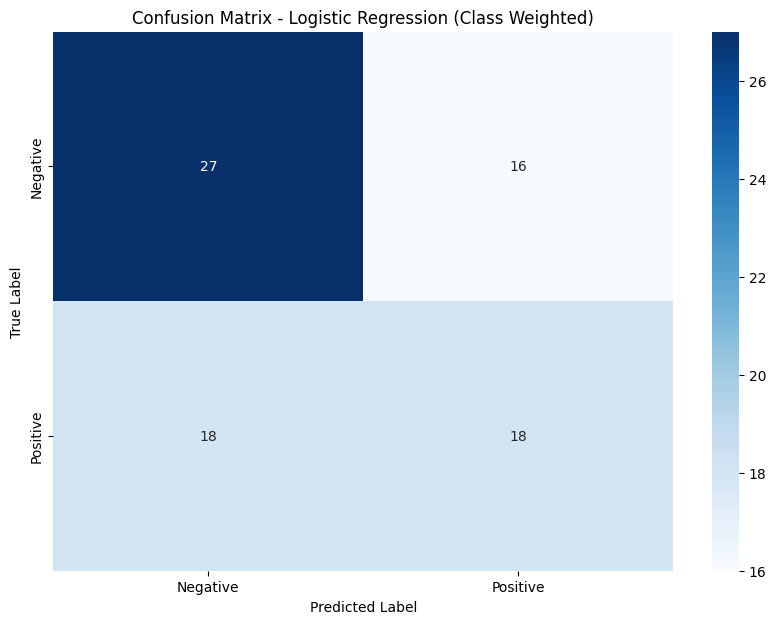

In [45]:
print("\n--- Section 11: Analysis of Best Model ---")

final_summary_for_best_model = None
if 'overall_summary_df_updated' in locals() and not overall_summary_df_updated.empty:
    final_summary_for_best_model = overall_summary_df_updated
elif 'overall_summary_df' in locals() and not overall_summary_df.empty: # Fallback if tuning section didn't run/update
    final_summary_for_best_model = overall_summary_df
else:
    print("No model performance summary available to determine the best model.")

best_model_object = None
y_pred_for_cm = None
best_model_name_for_plot = "N/A"

if final_summary_for_best_model is not None and not final_summary_for_best_model.empty:
    best_model_info = final_summary_for_best_model.loc[final_summary_for_best_model['Weighted F1-Score'].idxmax()]

    print(f"\n=== Detailed Analysis for Best Performing Configuration ===")
    print(best_model_info)

    best_scenario_name = best_model_info['Scenario']
    best_model_name = best_model_info['Model']
    best_model_name_for_plot = f"{best_model_name} ({best_scenario_name})"

    # **** NEW: Retrieve the model from trained_model_objects ****
    if best_scenario_name in trained_model_objects and \
       best_model_name in trained_model_objects[best_scenario_name]:
        best_model_object = trained_model_objects[best_scenario_name][best_model_name]
        print(f"\nSuccessfully retrieved model object: {best_model_name} from scenario: {best_scenario_name}")
    else:
        print(f"\nError: Could not retrieve model object for {best_model_name} from scenario {best_scenario_name}.")
        print("Please check if `trained_model_objects` was populated correctly in Sections 10 and 12.")

    if best_model_object:
        y_pred_for_cm = best_model_object.predict(X_test_final)

        print(f"\nClassification Report for {best_model_name_for_plot}:")
        # Ensure le (LabelEncoder) is available from Section 5 (Data Splitting)
        print(classification_report(y_test_final, y_pred_for_cm, target_names=le.classes_, zero_division=0))

        cm = confusion_matrix(y_test_final, y_pred_for_cm)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=le.classes_, yticklabels=le.classes_)
        plt.title(f'Confusion Matrix - {best_model_name_for_plot}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()
    else:
        print("\nCould not plot Confusion Matrix as the best model object was not retrieved.")

else:
    print("No results available to determine the best model for detailed analysis.")

## 12. Optional: Hyperparameter Tuning

In [46]:
print("\n--- Section 12: Optional Hyperparameter Tuning ---")

# ... (Keep the existing logic for choosing X_train_for_tuning, y_train_for_tuning) ...
# Defaulting to SMOTE'd data for this example:
if X_train_smote is not None and y_train_smote is not None and len(X_train_smote) > 0:
    X_train_for_tuning = X_train_smote
    y_train_for_tuning = y_train_smote
    tuning_data_description = 'SMOTE data'
    print("Using SMOTE'd training data for hyperparameter tuning.")
elif X_train_original_selected is not None and y_train_original is not None and len(X_train_original_selected) > 0:
    X_train_for_tuning = X_train_original_selected
    y_train_for_tuning = y_train_original
    tuning_data_description = 'Original data'
    print("Warning: SMOTE data not available or invalid. Using original selected training data for hyperparameter tuning.")
else:
    print("Critical Error: No valid training data available for hyperparameter tuning. Skipping.")
    X_train_for_tuning, y_train_for_tuning = None, None
    tuning_data_description = 'N/A'


if X_train_for_tuning is not None and y_train_for_tuning is not None: # Check if data is valid
    # ... (Keep param_dist_rf, cv_strategy, rf_template_for_tuning, random_search_rf setup) ...
    param_dist_rf = {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2'],
    }
    cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    rf_template_for_tuning = RandomForestClassifier(random_state=42, n_jobs=-1)
    random_search_rf = RandomizedSearchCV(
        estimator=rf_template_for_tuning,
        param_distributions=param_dist_rf,
        n_iter=15,
        cv=cv_strategy,
        verbose=1,
        random_state=42,
        n_jobs=-1,
        scoring='f1_weighted'
    )

    print("\n--- Starting Hyperparameter Tuning for Random Forest ---")
    start_time_tuning = datetime.now()
    random_search_rf.fit(X_train_for_tuning, y_train_for_tuning)
    end_time_tuning = datetime.now()
    # ... (Keep printing results: duration, best_params_, best_score_) ...
    print(f"Tuning Duration: {end_time_tuning - start_time_tuning}")
    print("\nBest Parameters found:")
    print(random_search_rf.best_params_)
    print("\nBest cross-validation score (Weighted F1-score):")
    print(random_search_rf.best_score_)

    best_rf_tuned = random_search_rf.best_estimator_
    y_pred_tuned = best_rf_tuned.predict(X_test_final)

    print("\n--- Performance of Tuned Random Forest on Test Set ---")
    report_tuned_str = classification_report(y_test_final, y_pred_tuned, target_names=le.classes_, zero_division=0)
    print(report_tuned_str)

    tuned_accuracy = metrics.accuracy_score(y_test_final, y_pred_tuned)
    tuned_report_dict = classification_report(y_test_final, y_pred_tuned, target_names=le.classes_, output_dict=True, zero_division=0)

    tuned_model_scenario_name = f"Tuned RF on {tuning_data_description}"
    tuned_model_model_name = "Random Forest Tuned"

    # **** NEW: Store the tuned model object ****
    if tuned_model_scenario_name not in trained_model_objects:
        trained_model_objects[tuned_model_scenario_name] = {}
    trained_model_objects[tuned_model_scenario_name][tuned_model_model_name] = best_rf_tuned

    all_results_summary.append({
            'Scenario': tuned_model_scenario_name,
            'Model': tuned_model_model_name,
            'Accuracy': tuned_accuracy,
            'Weighted F1-Score': tuned_report_dict['weighted avg']['f1-score']
        })

    overall_summary_df_updated = pd.DataFrame(all_results_summary)
    overall_summary_df_updated = overall_summary_df_updated.sort_values(by=['Weighted F1-Score'], ascending=False)
    print("\n=== Updated Overall Model Performance Summary (including Tuned RF) ===")
    print(overall_summary_df_updated)
else:
    print("Skipping hyperparameter tuning as training data is empty or None.")
    if 'overall_summary_df' in locals(): # If section 10 ran, use its summary
        overall_summary_df_updated = overall_summary_df.copy()
        print("\n=== Model Performance Summary (Tuning Skipped) ===")
        print(overall_summary_df_updated)
    else: # If section 10 also didn't produce results
        overall_summary_df_updated = pd.DataFrame() # Empty dataframe



--- Section 12: Optional Hyperparameter Tuning ---
Using SMOTE'd training data for hyperparameter tuning.

--- Starting Hyperparameter Tuning for Random Forest ---
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Tuning Duration: 0:00:13.626266

Best Parameters found:
{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 30}

Best cross-validation score (Weighted F1-score):
0.6638242180268888

--- Performance of Tuned Random Forest on Test Set ---
              precision    recall  f1-score   support

    Negative       0.68      0.70      0.69        43
    Positive       0.63      0.61      0.62        36

    accuracy                           0.66        79
   macro avg       0.66      0.65      0.65        79
weighted avg       0.66      0.66      0.66        79


=== Updated Overall Model Performance Summary (including Tuned RF) ===
                  Scenario                Model  Accuracy_CV  Weighted_F1_CV  \
18  

## 13. Deep Learning Exploration - 1D CNN


In [11]:
# ### 13.1 DL Data Preparation
# We will use the raw ECG signals corresponding to the same train/test split
# established in Section 5 for the classical ML models.
# The labels (y_train, y_test) from Section 5 will be one-hot encoded.

# %%
print("\n--- Section 13.1: Deep Learning Data Preparation ---")

# arr_shape is defined in Section 3 (e.g., 1000)
# le (LabelEncoder) is fitted in Section 5
# X_train, X_test, y_train, y_test are from Section 5 (after HRV features were dropped, but indices are key)

# Retrieve the original 'Raw Data' based on the indices from X_train and X_test
# This ensures we use the same data samples as the classical ML part.
# The 'X' DataFrame created in Section 5 (before HRV feature selection) holds the indices
# relative to 'simple_df' or 'features_df' if no simplification occurred.

# Reconstruct the DataFrame that X and y were originally derived from in Section 5
# This depends on whether label simplification was active in Section 5
df_for_dl_indices = None
if 'simple_df' in locals() and not simple_df.empty and 'valence_label' in simple_df.columns and y_target_series.name == 'valence_label':
    print("Using 'simple_df' for fetching raw ECG data for DL (based on simplified labels).")
    df_for_dl_indices = simple_df # This df was used to create X and y_target_series
elif 'features_df' in locals() and not features_df.empty:
    print("Using 'features_df' for fetching raw ECG data for DL (based on original 'emotion' labels).")
    df_for_dl_indices = features_df # This df was used if no simplification
else:
    raise ValueError("Could not determine the source DataFrame for X_train/X_test indices. Ensure Section 5 ran.")

# Get the raw ECG data using the indices stored in X_train and X_test
# X_train and X_test (from Section 5, before HRV feature selection/scaling) contain HRV features
# but their index corresponds to rows in df_for_dl_indices.
# The 'Raw Data' column is in `raw_dataframe` but needs to be aligned with `df_for_dl_indices`
# This assumes `df_for_dl_indices` has an index that can map back to `raw_dataframe`
# or that `df_for_dl_indices` itself contains 'Raw Data' if it was constructed carefully.

# Let's assume `df_for_dl_indices` was created from `features_df` which was created from `raw_dataframe`.
# `raw_dataframe` has a default RangeIndex. If `df_for_dl_indices` preserved this or has a compatible index:

# X_train.index and X_test.index refer to the indices of the rows in df_for_dl_indices
# that were selected for X_train and X_test. We need the 'Raw Data' from these specific rows.
# Assuming `df_for_dl_indices` has a 'Raw Data' column (if it's `features_df` which it might be)
# OR that its index is aligned with `raw_dataframe`.

# For safety, let's re-align using original `raw_dataframe` and the indices of `X` from section 5
# `X` in section 5 was created from `simple_df` or `features_df`. `X.index` has the correct indices.
# These indices refer to `simple_df` or `features_df`.
# And `simple_df`/`features_df` should have indices that align with `raw_dataframe`.

# Use the indices from X_train and X_test (which were split from X and y_encoded in Sec 5)
# These indices point to the rows in the dataframe `X` was originally based on.
# Let's assume `features_df` (which contains 'Raw Data') is the source for these indices.
# If `simple_df` was used, it should also contain 'Raw Data' or be alignable.

# Safest way: Re-fetch from `raw_dataframe` using original indices
# if `X_train.index` and `X_test.index` are from `df_for_dl_indices` which has original indices:
try:
    # Using original raw_dataframe which holds all 'Raw Data'
    # X_train.index and X_test.index are the indices from the dataframe that X was based on.
    # These indices should correspond to the original raw_dataframe if no re-indexing occurred without 'Raw Data'.
    # We need to ensure 'Raw Data' is directly accessible via these indices from a dataframe that contains it.
    # `features_df` was created from `raw_data_arr` and raw_dataframe was made from raw_data_arr.
    # So, indices of `features_df` (and thus `X_train`, `X_test`) should align with `raw_dataframe`.

    X_train_raw_ecg = np.array([raw_dataframe.loc[i, 'Raw Data'] for i in X_train.index])
    X_test_raw_ecg = np.array([raw_dataframe.loc[i, 'Raw Data'] for i in X_test.index])
    print(f"Successfully fetched raw ECG for DL: X_train_raw_ecg shape: {X_train_raw_ecg.shape}")
except KeyError as e:
    print(f"KeyError: {e}. This might mean indices from X_train/X_test do not directly map to 'raw_dataframe'.")
    print("Ensure 'raw_dataframe' contains all original signals and its index is consistent.")
    print("Consider adding 'Raw Data' to 'features_df' or 'simple_df' if it's not already there and using that directly.")
    # Fallback or error:
    # For now, if this fails, we cannot proceed with this DL approach easily.
    # You might need to restructure how 'Raw Data' is carried through or re-select it.
    # One common way is: `X_raw = raw_dataframe['Raw Data'].values`
    # Then split X_raw and y_original_emotion_labels together.
    # But to use the *exact same splits* as classical ML:
    if 'Raw Data' in features_df.columns: # If 'Raw Data' was kept in features_df
        print("Attempting to use 'Raw Data' from 'features_df'.")
        X_train_raw_ecg = np.array(features_df.loc[X_train.index, 'Raw Data'].tolist())
        X_test_raw_ecg = np.array(features_df.loc[X_test.index, 'Raw Data'].tolist())
    else:
        raise ValueError("Cannot find 'Raw Data' for DL preparation based on existing splits. Add 'Raw Data' to features_df or restructure.")


# Reshape for 1D CNN/LSTM: (n_samples, sequence_length, n_features=1)
X_train_dl = X_train_raw_ecg.reshape(X_train_raw_ecg.shape[0], arr_shape, 1)
X_test_dl = X_test_raw_ecg.reshape(X_test_raw_ecg.shape[0], arr_shape, 1)

# Normalize/Scale the ECG data
# Option 1: Sample-wise Z-score normalization (common for ECG)
# for i in range(X_train_dl.shape[0]):
#     X_train_dl[i] = (X_train_dl[i] - np.mean(X_train_dl[i])) / (np.std(X_train_dl[i]) + 1e-8) # Add epsilon for stability
# for i in range(X_test_dl.shape[0]):
#     X_test_dl[i] = (X_test_dl[i] - np.mean(X_test_dl[i])) / (np.std(X_test_dl[i]) + 1e-8)

# Option 2: StandardScaler fit on training data (channel-wise)
# This is more like image processing scaling if you consider the sequence one channel.
# For (n_samples, sequence_length, 1), this scales each time point across samples.
# Better to scale each signal independently (Option 1) or use a global min/max from training set.

# Option 3: Fit a scaler on the flattened training data and apply
# This scales based on global distribution of ECG values in training set
dl_scaler = StandardScaler()
# Fit on X_train_dl (reshaped), then transform X_train_dl and X_test_dl
X_train_dl_flat = X_train_dl.reshape(-1, 1) # Flatten to (n_samples*sequence_length, 1)
dl_scaler.fit(X_train_dl_flat)

X_train_dl = dl_scaler.transform(X_train_dl.reshape(-1, 1)).reshape(X_train_dl.shape)
X_test_dl = dl_scaler.transform(X_test_dl.reshape(-1, 1)).reshape(X_test_dl.shape)
print("ECG data scaled for DL.")

# One-hot encode labels (y_train and y_test are from Section 5)
num_classes = len(le.classes_) # le is the LabelEncoder from Section 5
y_train_dl_cat = to_categorical(y_train, num_classes=num_classes)
y_test_dl_cat = to_categorical(y_test, num_classes=num_classes)

print(f"X_train_dl shape: {X_train_dl.shape}, y_train_dl_cat shape: {y_train_dl_cat.shape}")
print(f"X_test_dl shape: {X_test_dl.shape}, y_test_dl_cat shape: {y_test_dl_cat.shape}")
print(f"Number of classes for DL: {num_classes}")


--- Section 13.1: Deep Learning Data Preparation ---
Using 'simple_df' for fetching raw ECG data for DL (based on simplified labels).
Successfully fetched raw ECG for DL: X_train_raw_ecg shape: (184, 1000)
ECG data scaled for DL.
X_train_dl shape: (184, 1000, 1), y_train_dl_cat shape: (184, 2)
X_test_dl shape: (79, 1000, 1), y_test_dl_cat shape: (79, 2)
Number of classes for DL: 2


### 13.2 Define 1D CNN Model

In [12]:
# ### 13.2 Define 1D CNN Model

# %%
print("\n--- Section 13.2: Defining 1D CNN Model ---")

cnn_model = Sequential()
# Block 1
cnn_model.add(Conv1D(filters=64, kernel_size=10, activation='relu', input_shape=(arr_shape, 1))) # arr_shape is sequence length
cnn_model.add(Conv1D(filters=64, kernel_size=10, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=3))
cnn_model.add(BatchNormalization()) # Added BatchNormalization
cnn_model.add(Dropout(0.3)) # Increased dropout

# Block 2
cnn_model.add(Conv1D(filters=128, kernel_size=7, activation='relu'))
cnn_model.add(Conv1D(filters=128, kernel_size=7, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=3))
cnn_model.add(BatchNormalization()) # Added BatchNormalization
cnn_model.add(Dropout(0.4)) # Increased dropout

# Block 3 (Optional, can add if sequence is still long enough)
# cnn_model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
# cnn_model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
# cnn_model.add(MaxPooling1D(pool_size=2))
# cnn_model.add(BatchNormalization())
# cnn_model.add(Dropout(0.5))

cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu')) # Reduced dense units
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(num_classes, activation='softmax')) # num_classes from DL Data Prep cell

optimizer = Adam(learning_rate=0.0005) # Adjusted learning rate
cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

cnn_model.summary()


--- Section 13.2: Defining 1D CNN Model ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 991, 64)        │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 982, 64)        │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 327, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 327, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 327, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 321, 128)       │        57,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 315, 128)       │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 105, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 105, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 105, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 13440)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,720,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,935,490 (7.38 MB)

 Trainable params: 1,935,106 (7.38 MB)

 Non-trainable params: 384 (1.50 KB)

### 13.3 Train 1D CNN Model


--- Section 13.3: Training 1D CNN Model ---
Training 1D CNN model with Batch Size: 16, Max Epochs: 50
Note: With a small dataset, this model is prone to overfitting.
Validation data below is the test set. This is for monitoring training, not for final unbiased evaluation.
Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 668ms/step - accuracy: 0.5196 - loss: 3.5138 - val_accuracy: 0.5063 - val_loss: 0.7027
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5155 - loss: 3.8120 - val_accuracy: 0.4430 - val_loss: 0.7116
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5377 - loss: 3.2778 - val_accuracy: 0.5443 - val_loss: 0.8446
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5114 - loss: 2.9939 - val_accuracy: 0.4557 - val_loss: 0.8769
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5506 - loss: 3.0307 - val_accuracy: 0.5443 - val_loss: 1.3435
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5360 - loss: 3.9342 - va

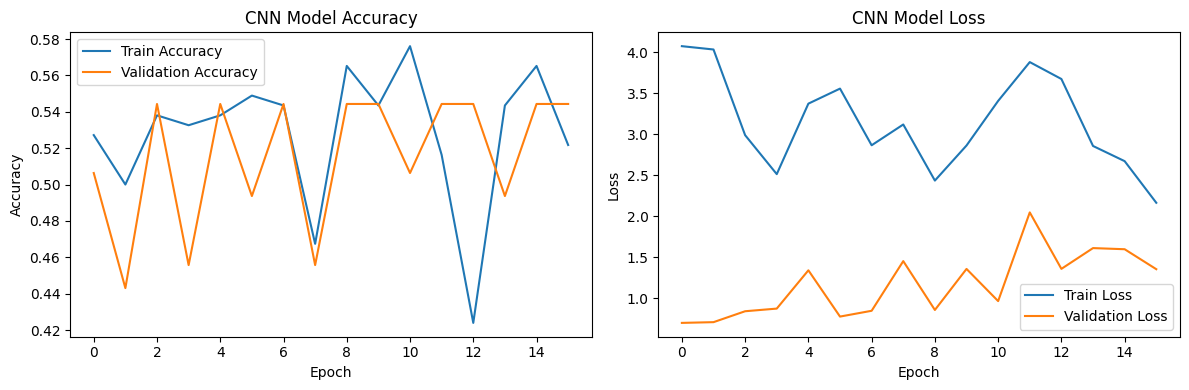

In [13]:
# %%
print("\n--- Section 13.3: Training 1D CNN Model ---")

# Callbacks
# Path to save the best model: ensure output_dir is defined (from Section 2)
cnn_model_checkpoint_path = os.path.join(output_dir, 'best_cnn_model.keras') # Use .keras format
model_checkpoint_callback = ModelCheckpoint(
    filepath=cnn_model_checkpoint_path,
    save_weights_only=False, # Save entire model
    monitor='val_accuracy',  # Monitor validation accuracy
    mode='max',              # Mode for val_accuracy
    save_best_only=True)     # Save only the best model

early_stopping_callback = EarlyStopping(
    monitor='val_loss',      # Monitor validation loss
    patience=15,             # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True) # Restores model weights from the epoch with the best value of the monitored quantity.

# Due to the very small dataset size, overfitting is highly likely.
# Use a small number of epochs and a portion of training data as validation.
# Or use X_test_dl for validation if you accept it's not a true hold-out for this training run.
# It's better to have a separate validation set if possible, but with ~280 training samples...
# Using X_test_dl for validation for now, but be mindful.
# A better approach for small data is K-Fold CV for DL, but it's more complex to set up.

BATCH_SIZE = 16 # Smaller batch size for smaller datasets
EPOCHS = 50 # Max epochs, early stopping will likely trigger sooner

print(f"Training 1D CNN model with Batch Size: {BATCH_SIZE}, Max Epochs: {EPOCHS}")
print("Note: With a small dataset, this model is prone to overfitting.")
print("Validation data below is the test set. This is for monitoring training, not for final unbiased evaluation.")

# Ensure X_train_dl and y_train_dl_cat are not empty
if X_train_dl.shape[0] == 0:
    print("X_train_dl is empty. Cannot train the model.")
else:
    history_cnn = cnn_model.fit(
        X_train_dl, y_train_dl_cat,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_test_dl, y_test_dl_cat), # Using test set as validation data here
        callbacks=[model_checkpoint_callback, early_stopping_callback],
        verbose=1)

    # Plot training history
    if 'history_cnn' in locals():
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
        plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
        plt.title('CNN Model Accuracy')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history_cnn.history['loss'], label='Train Loss')
        plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
        plt.title('CNN Model Loss')
        plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
        plt.tight_layout()
        plt.show()

### 13.4 Evaluate 1D CNN Model


--- Section 13.4: Evaluating 1D CNN Model ---

1D CNN Model - Test Accuracy: 50.63%
1D CNN Model - Test Loss: 0.7027
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step

Classification Report (1D CNN):
              precision    recall  f1-score   support

    Negative       0.56      0.42      0.48        43
    Positive       0.47      0.61      0.53        36

    accuracy                           0.51        79
   macro avg       0.52      0.51      0.51        79
weighted avg       0.52      0.51      0.50        79



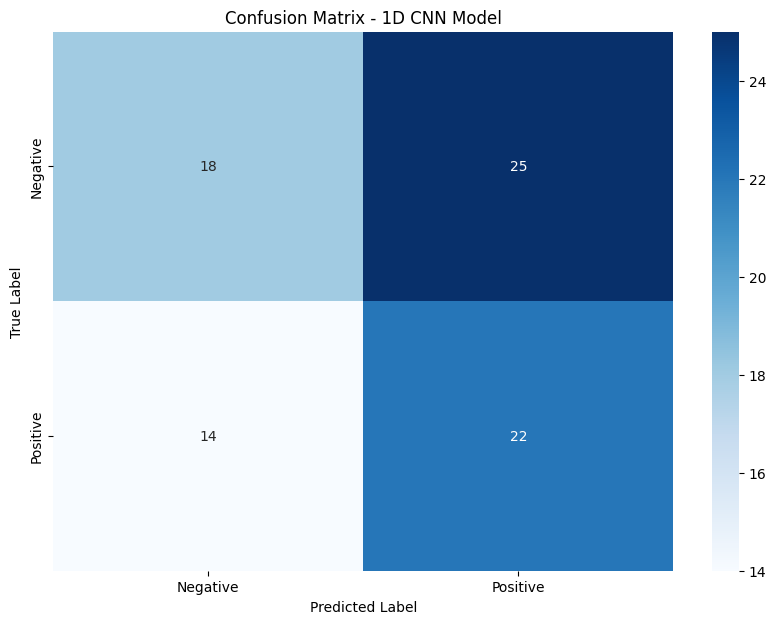

In [14]:
# %%
print("\n--- Section 13.4: Evaluating 1D CNN Model ---")

# Load the best model saved by ModelCheckpoint if early stopping restored best weights, this is already the best
# If not, or to be sure:
# from tensorflow.keras.models import load_model
# print(f"Loading best saved CNN model from: {cnn_model_checkpoint_path}")
# try:
#     best_cnn_model = load_model(cnn_model_checkpoint_path)
# except Exception as e:
#     print(f"Could not load saved model: {e}. Evaluating the current model instance.")
#     best_cnn_model = cnn_model # Fallback to current model instance

# EarlyStopping with restore_best_weights=True should mean cnn_model is already the best.
best_cnn_model = cnn_model

# Evaluate on the test set
if X_test_dl.shape[0] == 0:
    print("X_test_dl is empty. Cannot evaluate the model.")
else:
    loss_cnn, accuracy_cnn = best_cnn_model.evaluate(X_test_dl, y_test_dl_cat, verbose=0)
    print(f"\n1D CNN Model - Test Accuracy: {accuracy_cnn*100:.2f}%")
    print(f"1D CNN Model - Test Loss: {loss_cnn:.4f}")

    # Predictions
    y_pred_cnn_probs = best_cnn_model.predict(X_test_dl)
    y_pred_cnn_classes = np.argmax(y_pred_cnn_probs, axis=1)
    y_true_classes = np.argmax(y_test_dl_cat, axis=1) # Convert one-hot back to class indices

    # Classification Report
    print("\nClassification Report (1D CNN):")
    # le is the LabelEncoder from Section 5
    print(classification_report(y_true_classes, y_pred_cnn_classes, target_names=le.classes_, zero_division=0))

    # Confusion Matrix
    cm_cnn = confusion_matrix(y_true_classes, y_pred_cnn_classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('Confusion Matrix - 1D CNN Model')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

## 14. Deep Learning Exploration - LSTM Model

In [16]:
# ### 14.1 Define LSTM Model
# LSTMs are suitable for sequence data and can learn temporal dependencies.
# However, they can also be prone to overfitting on small datasets.

# %%
print("\n--- Section 14.1: Defining LSTM Model ---")

# Parameters from DL Data Preparation (Section 13.1):
# arr_shape, num_classes

lstm_model = Sequential()
# Using `input_shape=(arr_shape, 1)` where arr_shape is sequence_length and 1 is num_features_per_time_step
lstm_model.add(LSTM(64, return_sequences=True, input_shape=(arr_shape, 1)))
lstm_model.add(Dropout(0.4)) # Increased dropout

lstm_model.add(LSTM(32, return_sequences=False)) # Last LSTM layer before Dense
lstm_model.add(Dropout(0.4)) # Increased dropout

lstm_model.add(Dense(32, activation='relu')) # Reduced dense units
lstm_model.add(Dropout(0.5))

lstm_model.add(Dense(num_classes, activation='softmax'))

# Optimizer
optimizer_lstm = Adam(learning_rate=0.0005) # Potentially try a slightly larger LR for LSTMs, e.g., 0.001

lstm_model.compile(optimizer=optimizer_lstm, loss='categorical_crossentropy', metrics=['accuracy'])

lstm_model.summary()


--- Section 14.1: Defining LSTM Model ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1000, 64)       │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,434 (118.88 KB)

 Trainable params: 30,434 (118.88 KB)

 Non-trainable params: 0 (0.00 B)

### 14.2 Train LSTM Model



--- Section 14.2: Training LSTM Model ---
Training LSTM model with Batch Size: 16, Max Epochs: 60
Note: LSTMs on small datasets are very prone to overfitting.
Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.4970 - loss: 0.6975 - val_accuracy: 0.5443 - val_loss: 0.6915
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.5166 - loss: 0.6919 - val_accuracy: 0.5443 - val_loss: 0.6893
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.5439 - loss: 0.6944 - val_accuracy: 0.5443 - val_loss: 0.6885
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.5191 - loss: 0.6886 - val_accuracy: 0.5443 - val_loss: 0.6879
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.5681 - loss: 0.6796 - val_accuracy: 0.5443 - val_loss: 0.6888
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.5151 - loss: 0.6945 - val_accuracy: 0.5443 - val_loss: 0.6890
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5022 - loss: 

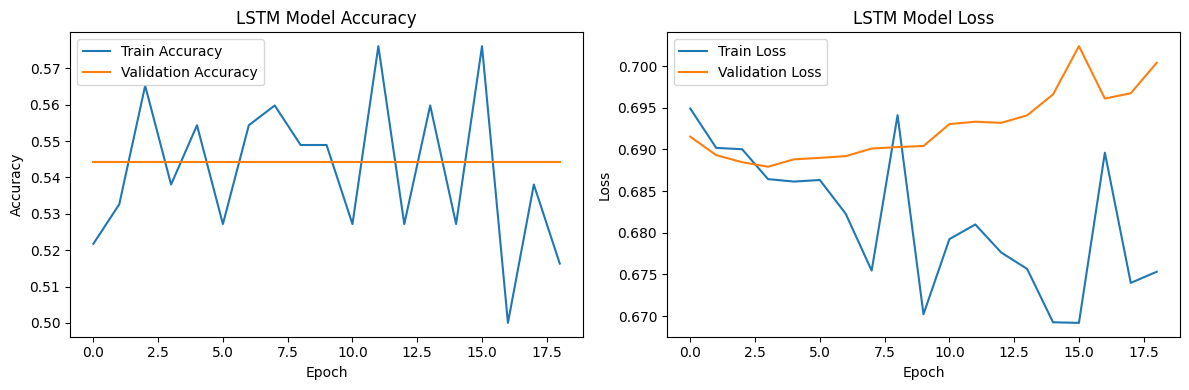

In [17]:
print("\n--- Section 14.2: Training LSTM Model ---")

# Callbacks
lstm_model_checkpoint_path = os.path.join(output_dir, 'best_lstm_model.keras')
lstm_model_checkpoint_callback = ModelCheckpoint(
    filepath=lstm_model_checkpoint_path,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

lstm_early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=15, # LSTM might take longer to converge or show overfitting
    verbose=1,
    restore_best_weights=True)

BATCH_SIZE_LSTM = 16 # Keep small due to dataset size
EPOCHS_LSTM = 60    # Allow more epochs as LSTMs can be slower to train; EarlyStopping is key

print(f"Training LSTM model with Batch Size: {BATCH_SIZE_LSTM}, Max Epochs: {EPOCHS_LSTM}")
print("Note: LSTMs on small datasets are very prone to overfitting.")

if X_train_dl.shape[0] == 0:
    print("X_train_dl is empty. Cannot train the LSTM model.")
else:
    history_lstm = lstm_model.fit(
        X_train_dl, y_train_dl_cat,
        epochs=EPOCHS_LSTM,
        batch_size=BATCH_SIZE_LSTM,
        validation_data=(X_test_dl, y_test_dl_cat),
        callbacks=[lstm_model_checkpoint_callback, lstm_early_stopping_callback],
        verbose=1)

    # Plot training history
    if 'history_lstm' in locals():
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
        plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
        plt.title('LSTM Model Accuracy')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history_lstm.history['loss'], label='Train Loss')
        plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
        plt.title('LSTM Model Loss')
        plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
        plt.tight_layout()
        plt.show()

### 14.3 Evaluate LSTM Model


--- Section 14.3: Evaluating LSTM Model ---

LSTM Model - Test Accuracy: 54.43%
LSTM Model - Test Loss: 0.6879
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step

Classification Report (LSTM):
              precision    recall  f1-score   support

    Negative       0.55      0.98      0.70        43
    Positive       0.50      0.03      0.05        36

    accuracy                           0.54        79
   macro avg       0.52      0.50      0.38        79
weighted avg       0.52      0.54      0.40        79



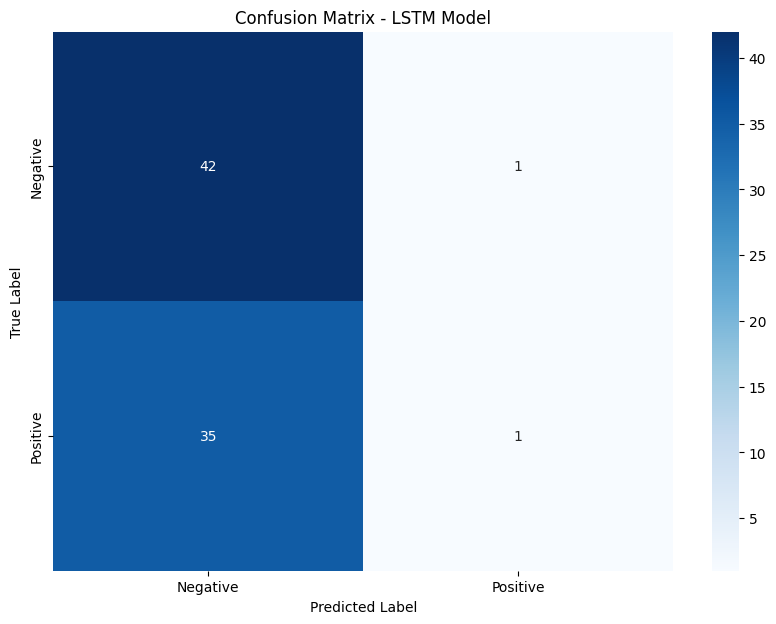

In [18]:
# %%
print("\n--- Section 14.3: Evaluating LSTM Model ---")

# EarlyStopping with restore_best_weights=True means lstm_model is already the best.
best_lstm_model = lstm_model

if X_test_dl.shape[0] == 0:
    print("X_test_dl is empty. Cannot evaluate the LSTM model.")
else:
    loss_lstm, accuracy_lstm = best_lstm_model.evaluate(X_test_dl, y_test_dl_cat, verbose=0)
    print(f"\nLSTM Model - Test Accuracy: {accuracy_lstm*100:.2f}%")
    print(f"LSTM Model - Test Loss: {loss_lstm:.4f}")

    # Predictions
    y_pred_lstm_probs = best_lstm_model.predict(X_test_dl)
    y_pred_lstm_classes = np.argmax(y_pred_lstm_probs, axis=1)
    y_true_classes_lstm = np.argmax(y_test_dl_cat, axis=1) # Same as y_true_classes for CNN

    # Classification Report
    print("\nClassification Report (LSTM):")
    print(classification_report(y_true_classes_lstm, y_pred_lstm_classes, target_names=le.classes_, zero_division=0))

    # Confusion Matrix
    cm_lstm = confusion_matrix(y_true_classes_lstm, y_pred_lstm_classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('Confusion Matrix - LSTM Model')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

## 15. Deep Learning Exploration - Simplified Transformer Model


### 15.1 Transformer Components

In [19]:
# Building a simplified Transformer Encoder block.
# Note: Transformers are highly data-intensive. This is for exploration on a small dataset
# and severe overfitting is expected without extensive regularization or pre-training.

# %%
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Add
from tensorflow.keras.models import Model

def transformer_encoder_block(inputs, head_size, num_heads, ff_dim, dropout_rate=0.2):
    # Attention and Normalization
    attn_output = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout_rate)(inputs, inputs)
    attn_output = Dropout(dropout_rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output) # Add & Norm

    # Feed Forward Part
    ffn_output = Dense(ff_dim, activation="relu")(out1)
    ffn_output = Dense(inputs.shape[-1])(ffn_output) # Project back to input dimension
    ffn_output = Dropout(dropout_rate)(ffn_output)
    return LayerNormalization(epsilon=1e-6)(out1 + ffn_output) # Add & Norm

# Positional Encoding: For simplicity, we'll use a learned Embedding layer as positional encoding for 1D data.
# The input to this embedding will be arange(sequence_length).
# This is a common simplification for 1D sequences.
# A fixed sinusoidal encoding is another option but more complex to implement here directly.

print("Transformer components defined.")

Transformer components defined.


### 15.2 Define Simplified Transformer Model


In [20]:
# %%
print("\n--- Section 15.2: Defining Simplified Transformer Model ---")

# Parameters from DL Data Preparation (Section 13.1):
# arr_shape, num_classes

# Transformer Hyperparameters (keep these small for your dataset)
HEAD_SIZE = 32      # Dimensionality of the key/query/value in MultiHeadAttention
NUM_HEADS = 2       # Number of attention heads
FF_DIM = 64         # Hidden layer size in feed forward network inside transformer
NUM_TRANSFORMER_BLOCKS = 1 # Number of transformer blocks (keep low)
EMBED_DIM = X_train_dl.shape[-1] # Should be 1 for raw ECG time series feature dimension
DROPOUT_RATE = 0.25

# Input layer
inputs = Input(shape=(arr_shape, EMBED_DIM)) # (sequence_length, feature_dim)

# --- Positional Encoding ---
# Create positions: 0, 1, 2, ..., arr_shape-1
positions = tf.range(start=0, limit=arr_shape, delta=1)
# Embed these positions. The embedding dimension should match the data's feature dimension.
# For raw ECG (feature_dim=1), this might not be the most effective way to use Embedding for PE.
# An alternative for single feature time series would be to add a learned embedding to the input
# or use fixed sinusoidal PE.
# For this example, we'll try a simple projection of the input sequence if EMBED_DIM needs to be larger for MHA
# Or, if EMBED_DIM=1, MHA might struggle. Let's try a dense projection first.

x = inputs
if EMBED_DIM < HEAD_SIZE * NUM_HEADS : # Project input to a higher dimension if needed for MHA
    print(f"Projecting input from {EMBED_DIM} to {HEAD_SIZE * NUM_HEADS} for Transformer.")
    x = Dense(HEAD_SIZE * NUM_HEADS, activation='relu')(x) # Project to a dimension MHA can work with

# Adding a basic learned positional embedding.
# This adds a learnable vector to each position in the sequence.
position_embedding_layer = Embedding(input_dim=arr_shape, output_dim=x.shape[-1])
positions_embedded = position_embedding_layer(positions)
x = x + positions_embedded # Add positional encoding

# --- Transformer Blocks ---
for _ in range(NUM_TRANSFORMER_BLOCKS):
    x = transformer_encoder_block(x, HEAD_SIZE, NUM_HEADS, FF_DIM, DROPOUT_RATE)

# --- Output ---
x = GlobalAveragePooling1D(data_format="channels_last")(x) # Or Flatten()
x = Dropout(0.4)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.4)(x)
outputs = Dense(num_classes, activation="softmax")(x)

transformer_model = Model(inputs=inputs, outputs=outputs)

optimizer_transformer = Adam(learning_rate=0.0005)
transformer_model.compile(optimizer=optimizer_transformer, loss="categorical_crossentropy", metrics=["accuracy"])

transformer_model.summary()


--- Section 15.2: Defining Simplified Transformer Model ---
Projecting input from 1 to 64 for Transformer.


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1000, 64)  │        128 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1000, 64)  │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1000, 64)  │     16,640 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 1000, 64)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1000, 64)  │          0 │ add[0][0],        │
│                     │                   │            │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 1000, 64)  │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1000, 64)  │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1000, 64)  │      4,160 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 1000, 64)  │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 1000, 64)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1000, 64)  │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 64)        │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      4,160 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64)        │          0 │ dense_7[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 2)         │        130 │ dropout_10[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,634 (115.76 KB)

 Trainable params: 29,634 (115.76 KB)

 Non-trainable params: 0 (0.00 B)

### 15.3 Train Simplified Transformer Model



--- Section 15.3: Training Simplified Transformer Model ---
Training Transformer model with Batch Size: 16, Max Epochs: 70
Epoch 1/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 655ms/step - accuracy: 0.4864 - loss: 0.9762 - val_accuracy: 0.5443 - val_loss: 0.7195
Epoch 2/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4595 - loss: 0.9136 - val_accuracy: 0.4937 - val_loss: 0.7013
Epoch 3/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5707 - loss: 0.7470 - val_accuracy: 0.5443 - val_loss: 0.6932
Epoch 4/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5136 - loss: 0.7581 - val_accuracy: 0.4684 - val_loss: 0.6983
Epoch 5/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5464 - loss: 0.7205 - val_accuracy: 0.5443 - val_loss: 0.6933
Epoch 6/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4497 - loss: 0.7364 - val_accuracy: 0.5316 - val_loss: 0.6896
Epoch 7/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6014 - loss: 0.6965 - val_accuracy: 0.4684 - va

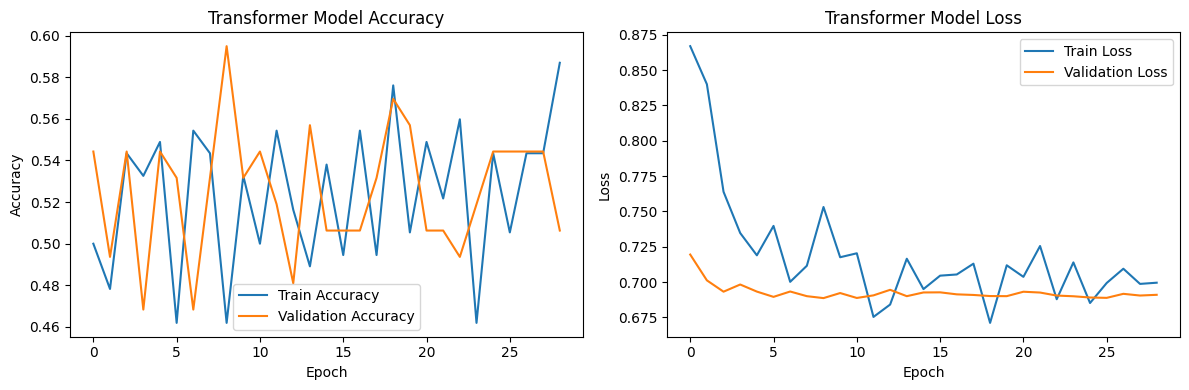

In [21]:
# %%
print("\n--- Section 15.3: Training Simplified Transformer Model ---")

# Callbacks
transformer_checkpoint_path = os.path.join(output_dir, 'best_transformer_model.keras')
transformer_model_checkpoint_callback = ModelCheckpoint(
    filepath=transformer_checkpoint_path,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

transformer_early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=20, # Transformers might need more patience
    verbose=1,
    restore_best_weights=True)

BATCH_SIZE_TRANSFORMER = 16
EPOCHS_TRANSFORMER = 70 # Transformers might need more epochs, but watch for overfitting

print(f"Training Transformer model with Batch Size: {BATCH_SIZE_TRANSFORMER}, Max Epochs: {EPOCHS_TRANSFORMER}")
print("WARNING: Transformers are very data-hungry. Expect overfitting on this small dataset.")

if X_train_dl.shape[0] == 0:
    print("X_train_dl is empty. Cannot train the Transformer model.")
else:
    history_transformer = transformer_model.fit(
        X_train_dl, y_train_dl_cat,
        epochs=EPOCHS_TRANSFORMER,
        batch_size=BATCH_SIZE_TRANSFORMER,
        validation_data=(X_test_dl, y_test_dl_cat),
        callbacks=[transformer_model_checkpoint_callback, transformer_early_stopping_callback],
        verbose=1)

    # Plot training history
    if 'history_transformer' in locals():
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history_transformer.history['accuracy'], label='Train Accuracy')
        plt.plot(history_transformer.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Transformer Model Accuracy')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history_transformer.history['loss'], label='Train Loss')
        plt.plot(history_transformer.history['val_loss'], label='Validation Loss')
        plt.title('Transformer Model Loss')
        plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
        plt.tight_layout()
        plt.show()

### 15.4 Evaluate Simplified Transformer Model



--- Section 15.4: Evaluating Simplified Transformer Model ---

Transformer Model - Test Accuracy: 59.49%
Transformer Model - Test Loss: 0.6887


1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 392ms/step

Classification Report (Transformer):
              precision    recall  f1-score   support

    Negative       0.60      0.74      0.67        43
    Positive       0.58      0.42      0.48        36

    accuracy                           0.59        79
   macro avg       0.59      0.58      0.58        79
weighted avg       0.59      0.59      0.58        79



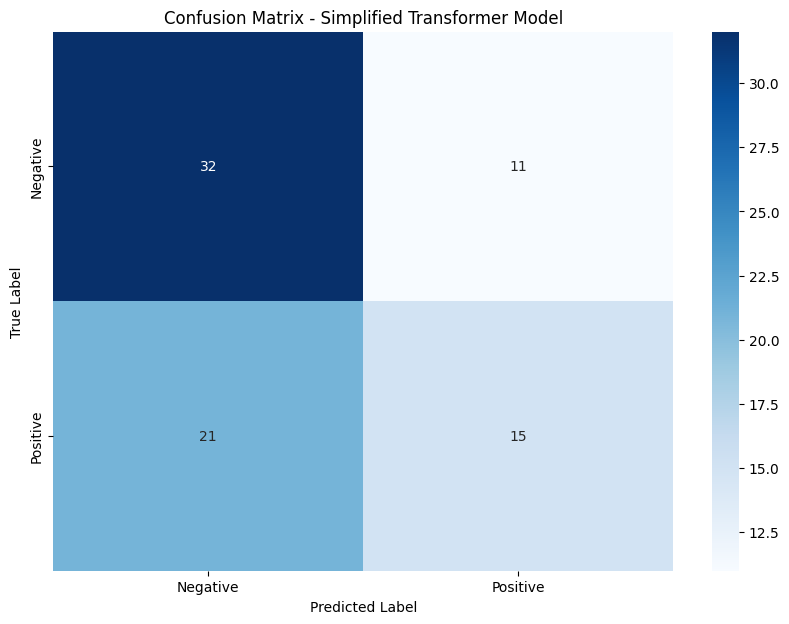

In [22]:
# %%
print("\n--- Section 15.4: Evaluating Simplified Transformer Model ---")

best_transformer_model = transformer_model # Due to restore_best_weights=True

if X_test_dl.shape[0] == 0:
    print("X_test_dl is empty. Cannot evaluate the Transformer model.")
else:
    loss_transformer, accuracy_transformer = best_transformer_model.evaluate(X_test_dl, y_test_dl_cat, verbose=0)
    print(f"\nTransformer Model - Test Accuracy: {accuracy_transformer*100:.2f}%")
    print(f"Transformer Model - Test Loss: {loss_transformer:.4f}")

    y_pred_transformer_probs = best_transformer_model.predict(X_test_dl)
    y_pred_transformer_classes = np.argmax(y_pred_transformer_probs, axis=1)
    y_true_classes_transformer = np.argmax(y_test_dl_cat, axis=1)

    print("\nClassification Report (Transformer):")
    print(classification_report(y_true_classes_transformer, y_pred_transformer_classes, target_names=le.classes_, zero_division=0))

    cm_transformer = confusion_matrix(y_true_classes_transformer, y_pred_transformer_classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_transformer, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('Confusion Matrix - Simplified Transformer Model')
    plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.show()